<a class="anchor" id="second-bullet">

# 1. Data Integration

## 1.1  Import Libraries <a class="anchor" id="2.1"></a>

In [147]:
# Necessary installations

#!pip install squarify
#!pip install seaborn
#!pip install matplotlib
#!pip install numpy
#!pip install pandas
#!pip install scikit-learn
#!pip install scipy


# Necessary imports

# hiding the warnings
import warnings

warnings.filterwarnings('ignore')
import os, sys

sys.stderr = open(os.devnull, "w")  # silence stderr
sys.stderr = sys.__stderr__  # unsilence stderr

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import squarify

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

# for better resolution plots
%config InlineBackend.figure_format = 'retina'

# hierarchical clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, MeanShift, DBSCAN, estimate_bandwidth
from scipy.cluster.hierarchy import dendrogram
from sklearn.base import clone
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.mixture import GaussianMixture

# setting the style of seaborn
sns.set(rc={'figure.figsize':(11.7,8.27)})

## 1.2 Import Data <a class="anchor" id="2.2"></a>

In [148]:
# Importing the dataset
final_df_ohc = pd.read_csv('DM2425_ABCDEats_DATASET_Preprocessed.csv', index_col="customer_id")

## 1.3. Check data integrity

In [149]:
print(f"NaN Count: {final_df_ohc.isna().sum().sum()}")
print(f"Infinite Count: {final_df_ohc.isin([np.inf, -np.inf]).sum().sum()}")

final_df_ohc.head()

NaN Count: 0
Infinite Count: 0


Week_days_mean  Weekend_days_mean   HR_peak  DOW_Peak  \
customer_id                                                          
1b8f824d5e        -0.445376          -0.431336  1.208591 -1.320198   
5d272b9dcb        -0.445376          -0.431336 -0.284567 -1.320198   
f6d1b2ba63        -0.445376          -0.431336 -0.471211 -1.320198   
180c632ed8        -0.445376          -0.431336 -0.097922 -0.825941   
4eb37a6705        -0.445376          -0.431336 -0.657856 -0.825941   

             customer_age  CUI_American  CUI_Italian  CUI_Asian  CUI_OTHER  \
customer_id                                                                  
1b8f824d5e      -1.446788     -0.456579     -0.31153   0.453449  -0.594483   
5d272b9dcb      -1.605453      0.813936     -0.31153  -0.397661  -0.594483   
f6d1b2ba63       1.726520      0.455179     -0.31153  -0.639483  -0.594483   
180c632ed8      -0.177464     -0.456579     -0.31153   0.554871  -0.594483   
4eb37a6705      -1.129457      0.987368     -0.31153   0.907197  -0.594483   

             Chain_Preference  Order_Frequency  Avg_Spend_per_Order  \
customer_id                                                           
1b8f824d5e          -0.331571         1.561888             0.536321   
5d272b9dcb           0.960027         1.561888            -0.082694   
f6d1b2ba63           0.960027         1.561888            -0.723473   
180c632ed8          -0.331571         0.757988             0.707879   
4eb37a6705          -1.623169         0.757988             2.236531   

             Product_per_Order  Total_Orders  Customer_Duration  Recency  \
customer_id                                                                
1b8f824d5e            2.912290     -0.506478          -1.170403        1   
5d272b9dcb           -0.715329     -0.506478          -1.170403        1   
f6d1b2ba63           -0.715329     -0.506478          -1.170403        1   
180c632ed8            0.493877     -0.506478          -1.136119        2   
4eb37a6705            2.912290     -0.506478          -1.136119        2   

             Frequency  Monetary  
customer_id                       
1b8f824d5e           2     28.88  
5d272b9dcb           2     19.21  
f6d1b2ba63           2      9.20  
180c632ed8           2     31.56  
4eb37a6705           2     55.44

## 1.4. Creating perspectives

In [150]:
df_BEHAV = final_df_ohc[['CUI_American', 'CUI_Italian', 'CUI_Asian', 'CUI_OTHER',
       'Chain_Preference', 'Order_Frequency', 'Avg_Spend_per_Order',
       'Product_per_Order', 'Total_Orders', 'Customer_Duration']]

df_DEMO = final_df_ohc[['Week_days_mean', 'Weekend_days_mean', 'HR_peak', 'DOW_Peak',
       'customer_age']]

df_RFM = final_df_ohc[['Recency', 'Frequency', 'Monetary']]

final_df_ohc.drop(columns=df_RFM.columns, inplace=True)

The clustering and RFM segmentation techniques are going to be applied to this dataframes individually. Then we will merge the clustering results and use RFM insights to help interpret our clusters.

# 2. Cell-based segmentation

## Recency Frequency Monetary (RFM) analysis

In [226]:
# Apply qcut
r = pd.qcut(df_RFM["Recency"], q=4, labels=range(1, 5))
f = pd.qcut(df_RFM["Frequency"], q=4, labels=range(1, 5))
m = pd.qcut(df_RFM["Monetary"], q=4, labels=range(1, 5))

df_RFM = df_RFM.assign(R = r.values, F = f.values, M = m.values)
df_RFM["RFM_Group"] = df_RFM[["R", "F", "M"]].apply(lambda x: "-".join(x.astype(str)), axis=1)
df_RFM["RFM_Score"] = df_RFM[["R", "F", "M"]].astype(int).sum(axis=1)

df_RFM.head()

Recency  Frequency  Monetary  R  F  M RFM_Group  RFM_Score
customer_id                                                            
1b8f824d5e         1          2     28.88  1  1  3     1-1-3          5
5d272b9dcb         1          2     19.21  1  1  2     1-1-2          4
f6d1b2ba63         1          2      9.20  1  1  1     1-1-1          3
180c632ed8         2          2     31.56  1  1  3     1-1-3          5
4eb37a6705         2          2     55.44  1  1  4     1-1-4          6

Checking total number of distinct rfm groups:

In [227]:
print(f"{df_RFM["RFM_Group"].nunique()} groups")

64 groups


### Rollout

Let's take a look at the raw distribution of the groups

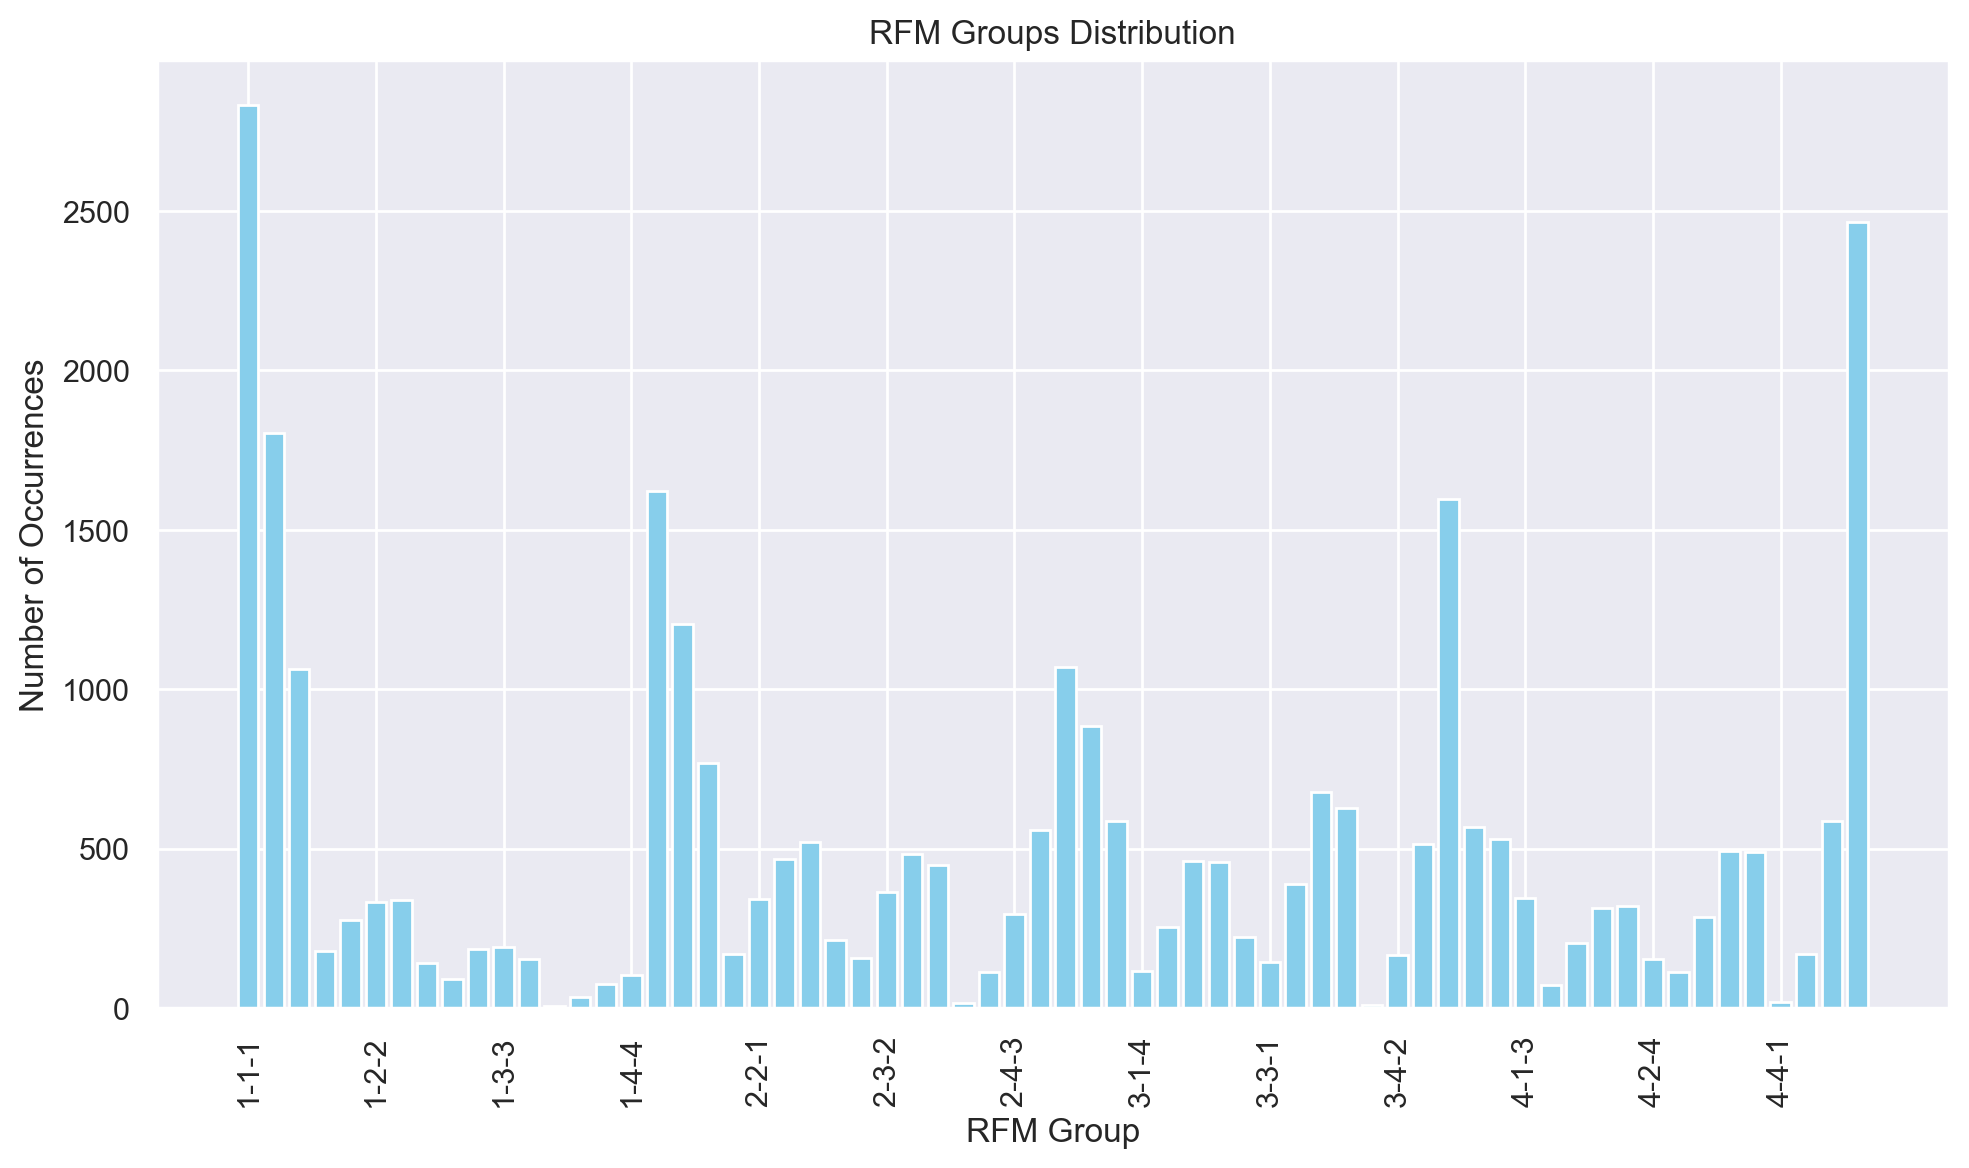

In [228]:
# Step 1: Count the occurrences of each RFM_Group
rfm_counts = df_RFM.groupby(["RFM_Group"]).size().reset_index(name='count')

# Step 2: Plot the result using bar plot (since we are dealing with counts of categories)
plt.figure(figsize=(10, 6))
plt.bar(rfm_counts["RFM_Group"], rfm_counts["count"], color="skyblue")

# Adding labels and title
plt.title("RFM Groups Distribution")
plt.xlabel("RFM Group")
plt.ylabel("Number of Occurrences")

# Show only some x-axis labels (subset of indices)
step = 5  # This controls the frequency of labels to display (every 2nd label)
x_ticks = rfm_counts["RFM_Group"][::step]  # Take every 'step' label
plt.xticks(x_ticks, rotation=90)  # Display those labels

# Displaying the plot
plt.tight_layout()
plt.show()

Using RFM total scores to create more comprehensible groups:

### RFM value segments

In [229]:
df_RFM["RFM_Segment"] = ''

df_RFM.loc[df_RFM["RFM_Score"] > 8, 'RFM_Segment'] = 'High-Value'
df_RFM.loc[(df_RFM["RFM_Score"] > 4) & (df_RFM["RFM_Score"] <= 8), 'RFM_Segment'] = 'Mid-Value'
df_RFM.loc[df_RFM["RFM_Score"] <= 4, 'RFM_Segment'] = 'Low-Value'

df_RFM.head()

Recency  Frequency  Monetary  R  F  M RFM_Group  RFM_Score  \
customer_id                                                               
1b8f824d5e         1          2     28.88  1  1  3     1-1-3          5   
5d272b9dcb         1          2     19.21  1  1  2     1-1-2          4   
f6d1b2ba63         1          2      9.20  1  1  1     1-1-1          3   
180c632ed8         2          2     31.56  1  1  3     1-1-3          5   
4eb37a6705         2          2     55.44  1  1  4     1-1-4          6   

            RFM_Segment  
customer_id              
1b8f824d5e    Mid-Value  
5d272b9dcb    Low-Value  
f6d1b2ba63    Low-Value  
180c632ed8    Mid-Value  
4eb37a6705    Mid-Value

The value segments are the following:

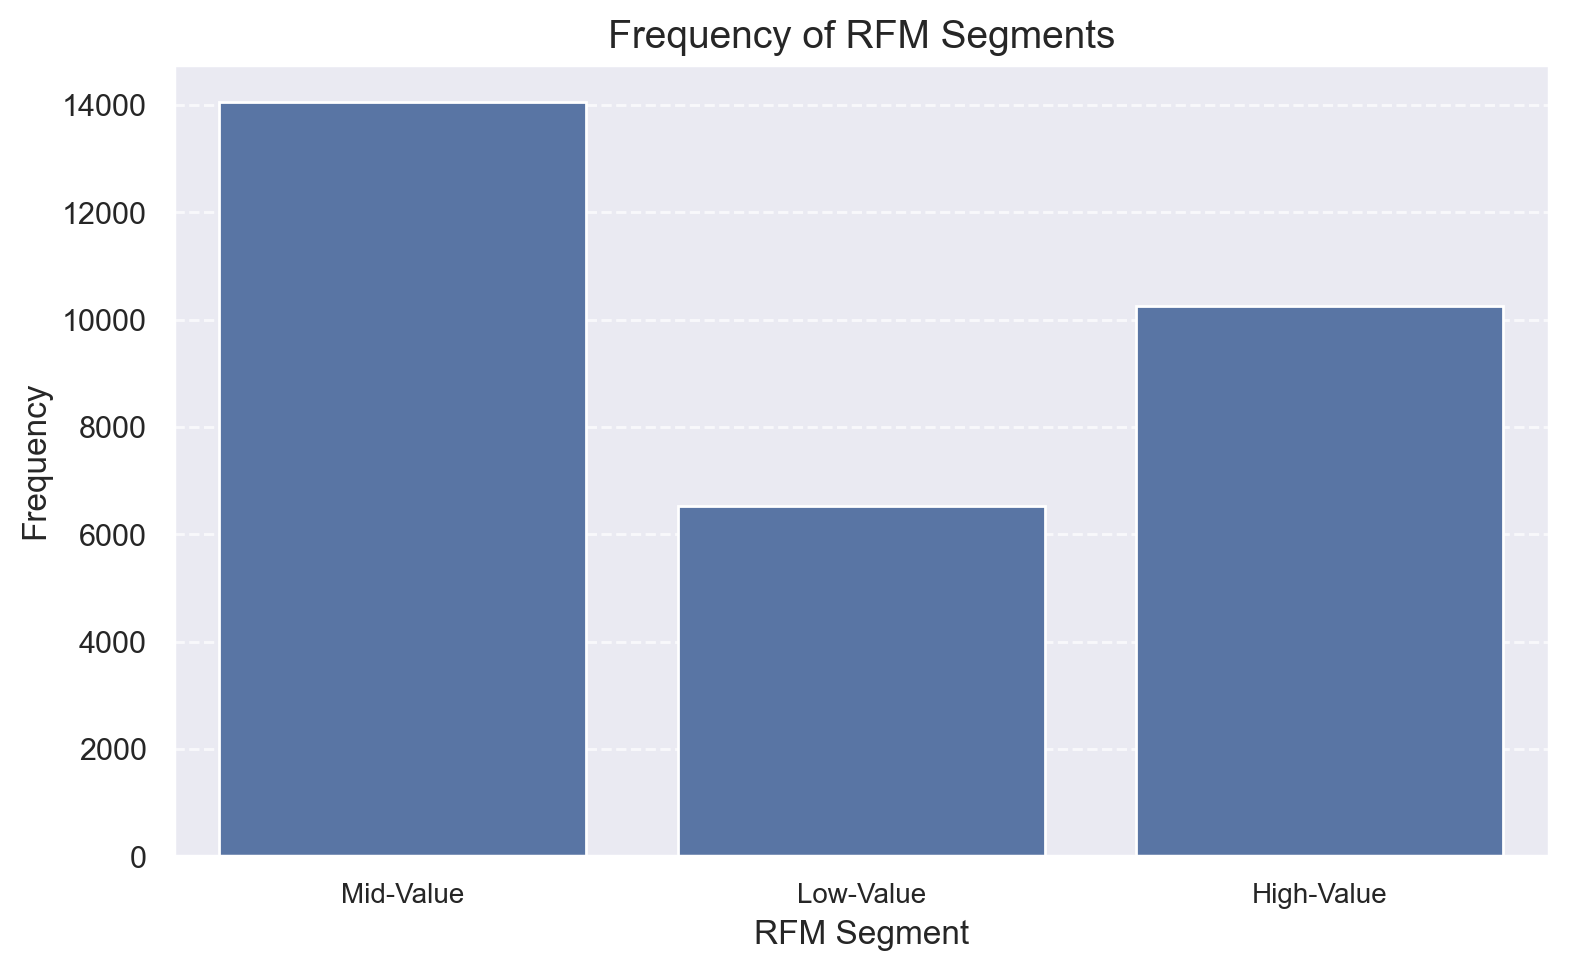

In [230]:
# Create the barplot
plt.figure(figsize=(8, 5))
sns.countplot(data=df_RFM, x='RFM_Segment')

# Customize the plot
plt.title('Frequency of RFM Segments', fontsize=14)
plt.xlabel('RFM Segment', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

### RFM value group

In [231]:
df_RFM["RFM_Vgroup"] = ''

# High-Value
df_RFM.loc[df_RFM["RFM_Score"] == 12, 'RFM_Vgroup'] = 'VIP'
df_RFM.loc[(df_RFM["RFM_Score"] >= 9) & (df_RFM["RFM_Score"] < 12), 'RFM_Vgroup'] = 'Very Loyal'

# Mid-Value
df_RFM.loc[(df_RFM["RFM_Score"] >= 7) & (df_RFM["RFM_Score"] < 9), 'RFM_Vgroup'] = 'Loyal'
df_RFM.loc[(df_RFM["RFM_Score"] >= 5) & (df_RFM["RFM_Score"] < 7), 'RFM_Vgroup'] = 'At Risk'

# Low-Value
df_RFM.loc[df_RFM["RFM_Score"] == 4, 'RFM_Vgroup'] = 'Almost Lost'
df_RFM.loc[df_RFM["RFM_Score"] == 3, 'RFM_Vgroup'] = 'Lost'

df_RFM.head()

Recency  Frequency  Monetary  R  F  M RFM_Group  RFM_Score  \
customer_id                                                               
1b8f824d5e         1          2     28.88  1  1  3     1-1-3          5   
5d272b9dcb         1          2     19.21  1  1  2     1-1-2          4   
f6d1b2ba63         1          2      9.20  1  1  1     1-1-1          3   
180c632ed8         2          2     31.56  1  1  3     1-1-3          5   
4eb37a6705         2          2     55.44  1  1  4     1-1-4          6   

            RFM_Segment   RFM_Vgroup  
customer_id                           
1b8f824d5e    Mid-Value      At Risk  
5d272b9dcb    Low-Value  Almost Lost  
f6d1b2ba63    Low-Value         Lost  
180c632ed8    Mid-Value      At Risk  
4eb37a6705    Mid-Value      At Risk

The value groups are the following:

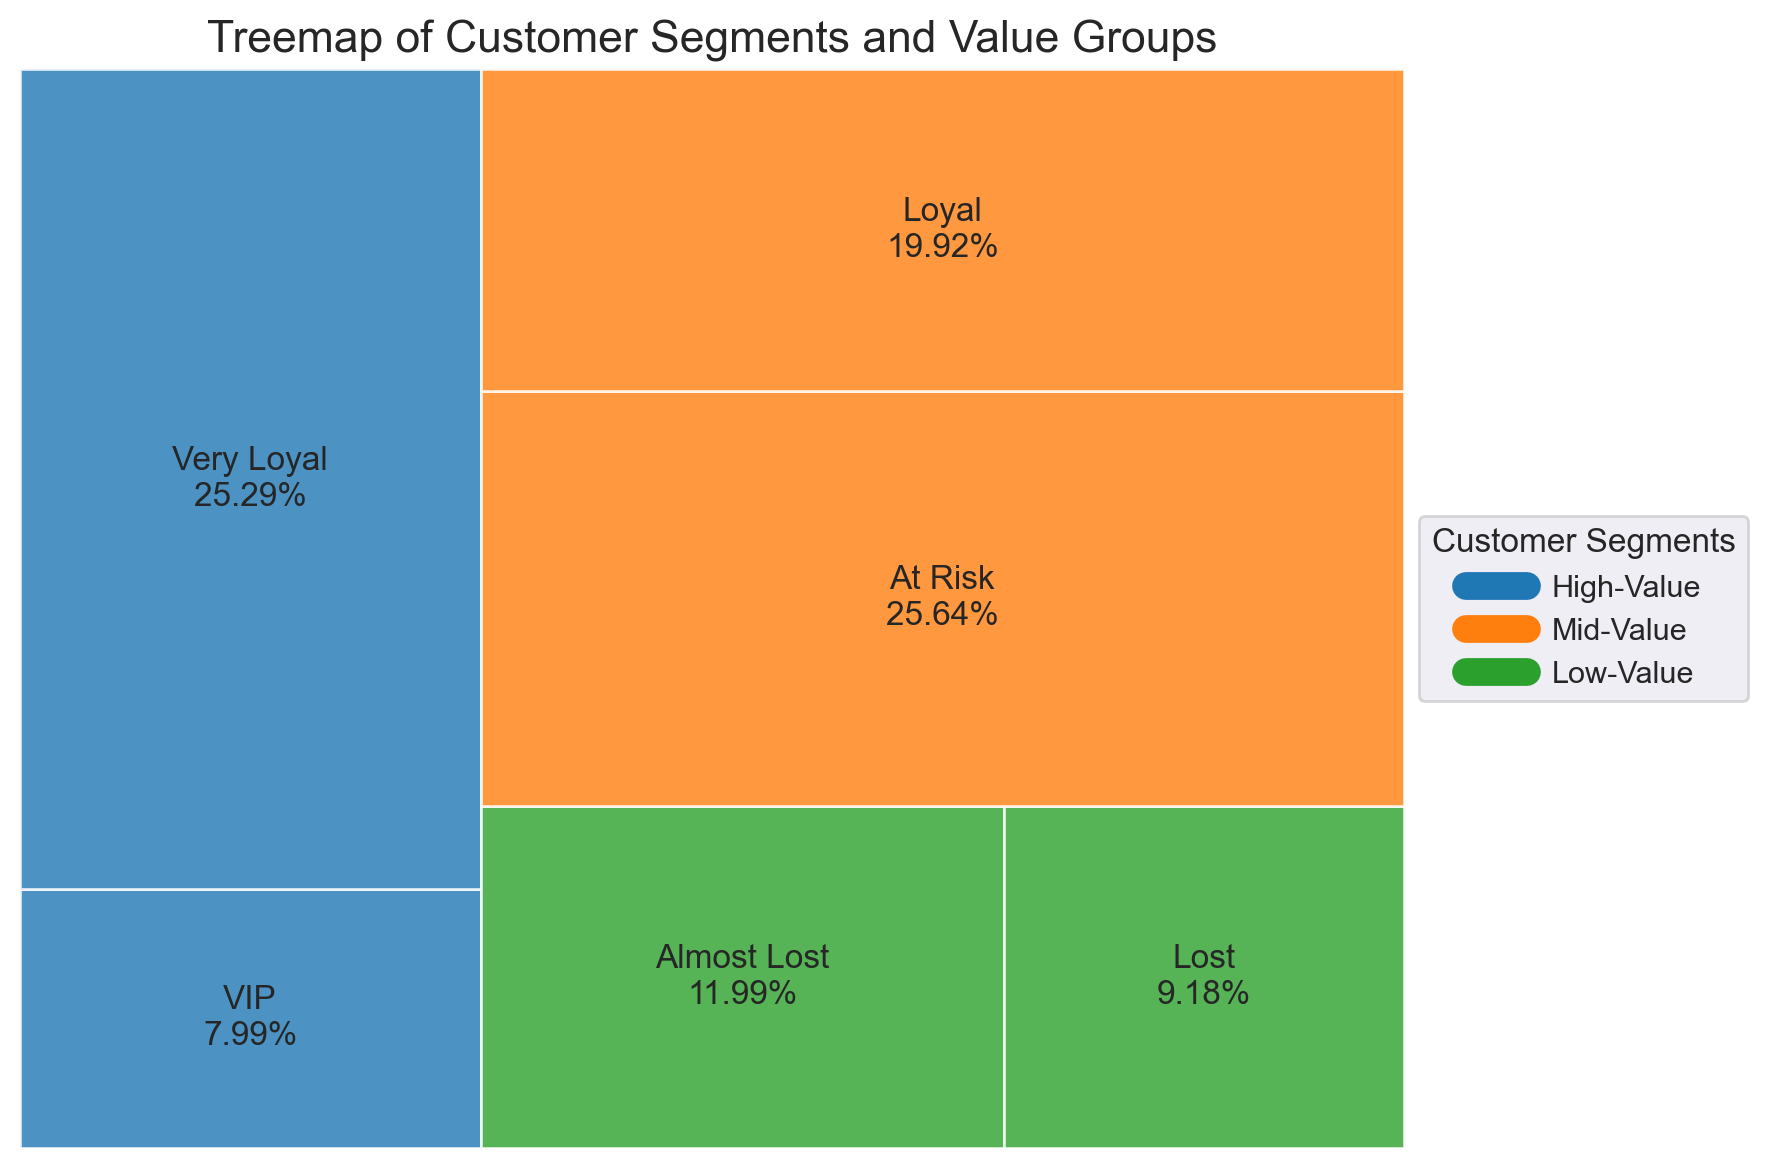

In [232]:
# Assuming df_RFM is your DataFrame
# Group by RFM_Segment and RFM_Vgroup to calculate frequencies
aggregated_data = df_RFM.groupby(['RFM_Segment', 'RFM_Vgroup']).size().reset_index(name='Frequency')

# Calculate percentages
total_count = aggregated_data['Frequency'].sum()
aggregated_data['Percentage'] = (aggregated_data['Frequency'] / total_count) * 100

# Prepare the data for the treemap
sizes = aggregated_data['Percentage']  # Use percentages for sizes
labels = aggregated_data['RFM_Vgroup'] + "\n" + aggregated_data['Percentage'].round(2).astype(str) + "%"  # Display percentages

# Assign colors for RFM segments
colors = {
    'High-Value': '#1f77b4',
    'Mid-Value': '#ff7f0e',
    'Low-Value': '#2ca02c'
}
aggregated_data['Color'] = aggregated_data['RFM_Segment'].map(colors)

# Create the treemap
plt.figure(figsize=(9, 6))
squarify.plot(sizes=sizes, label=labels, color=aggregated_data['Color'], alpha=0.8)
plt.axis('off')
plt.title('Treemap of Customer Segments and Value Groups', fontsize=16)

# Add legend for customer segments
legend_labels = [f"{segment}: {color}" for segment, color in colors.items()]
legend_handles = [plt.Line2D([0], [0], color=color, lw=10) for color in colors.values()]
plt.legend(legend_handles, colors.keys(), title="Customer Segments", bbox_to_anchor=(1, 0.5), loc='center left')

# Show the plot
plt.tight_layout()
plt.show()

# 3. Clustering

## 3.1. K-means and Hierarchical clustering <a class="anchor" id="5.1"></a>

Testing on K-means and Hierarchical clustering

In [151]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst

def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


In [152]:
# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

Finding the optimal clusterer on Demographic variables

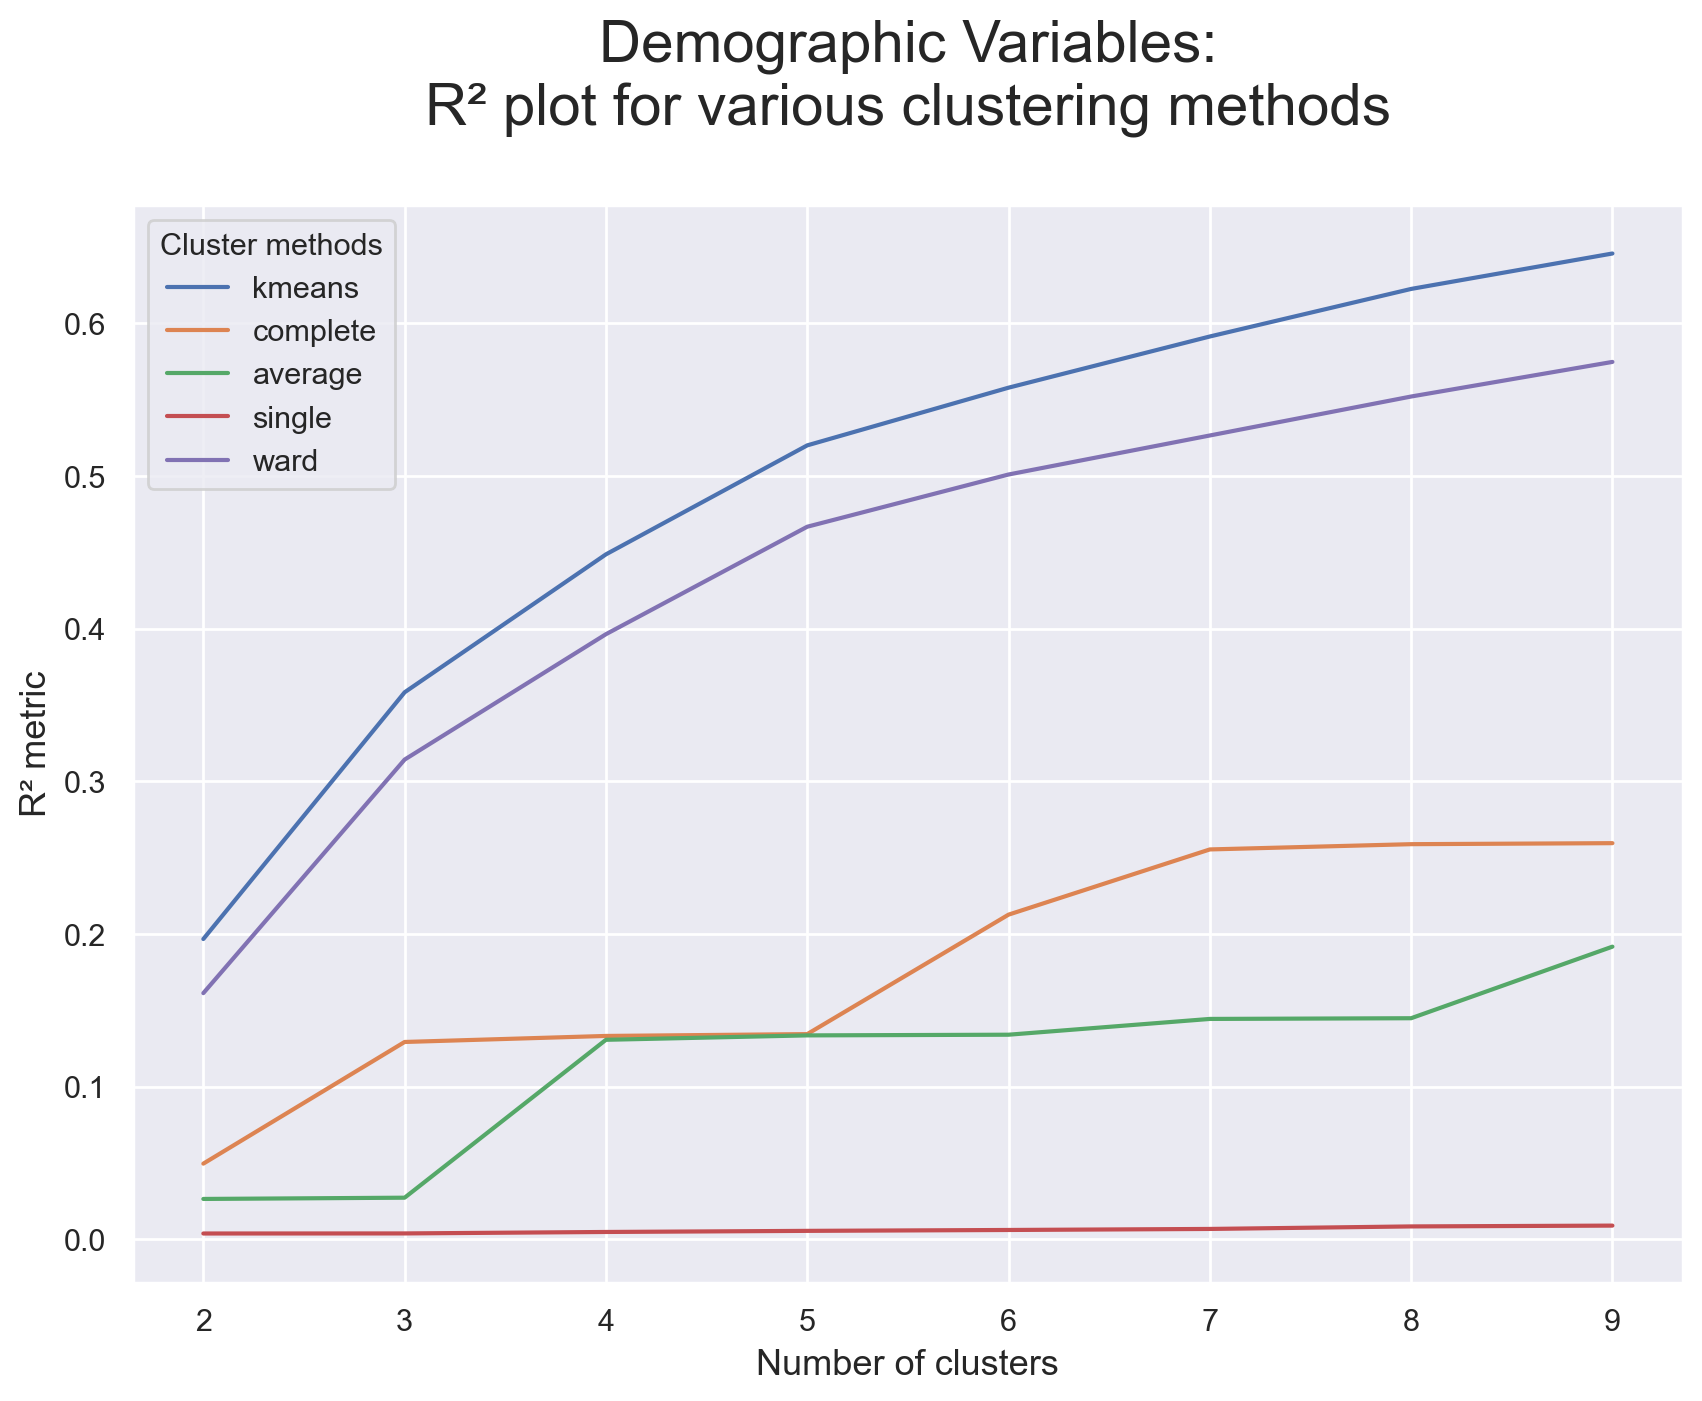

In [7]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_DEMO, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_DEMO, hierarchical.set_params(linkage=linkage)
    )

# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

We can see the presence of 5 clusters.

Repeat the process for Behavior variables

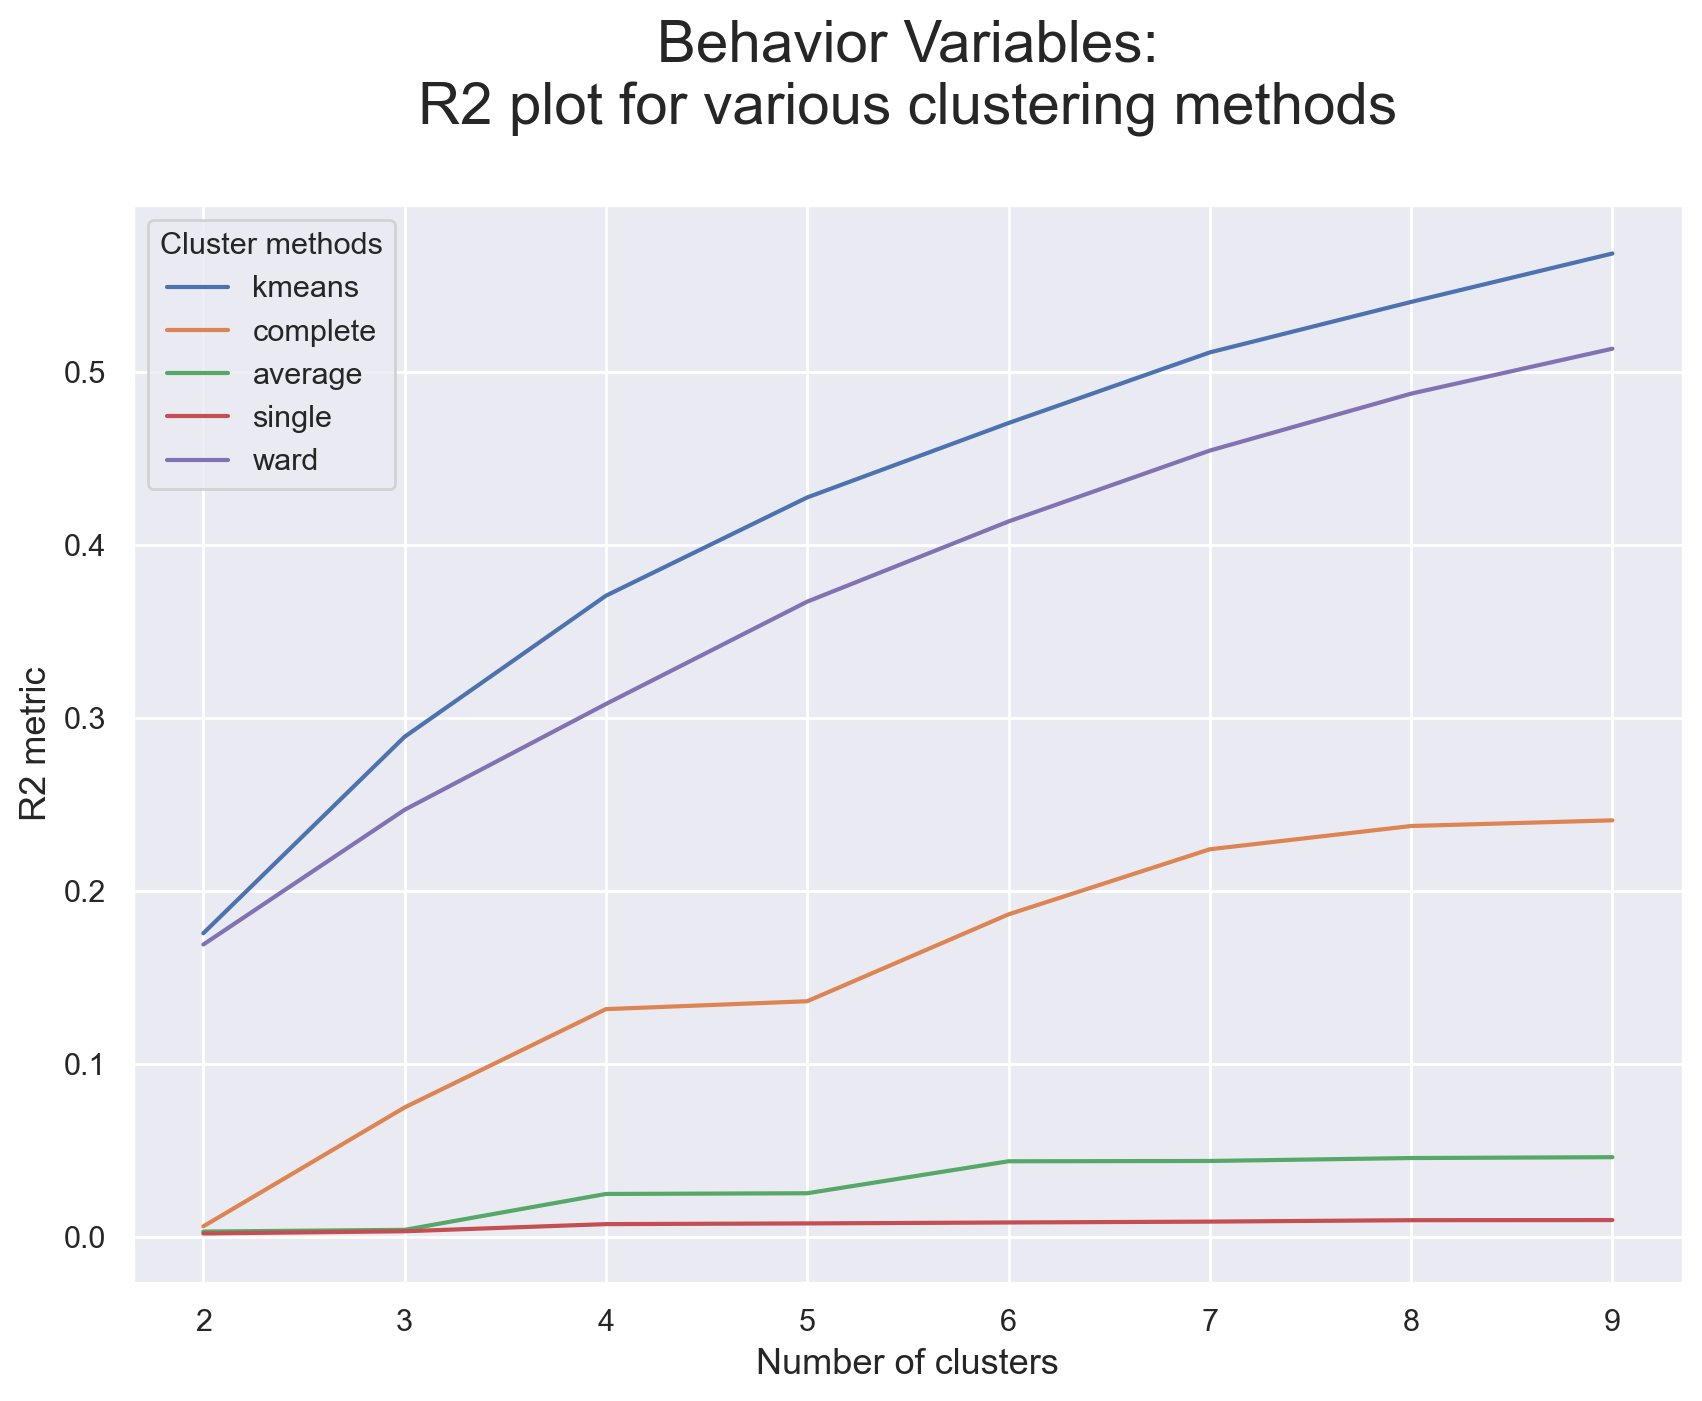

In [125]:
# Obtaining the R² scores for each cluster solution on Behavior variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_BEHAV, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_BEHAV, hierarchical.set_params(linkage=linkage)
    )

# Visualizing the R² scores for each cluster solution on Behavior variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Behavior Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

Once more, the presence of 5 clusters is detected.

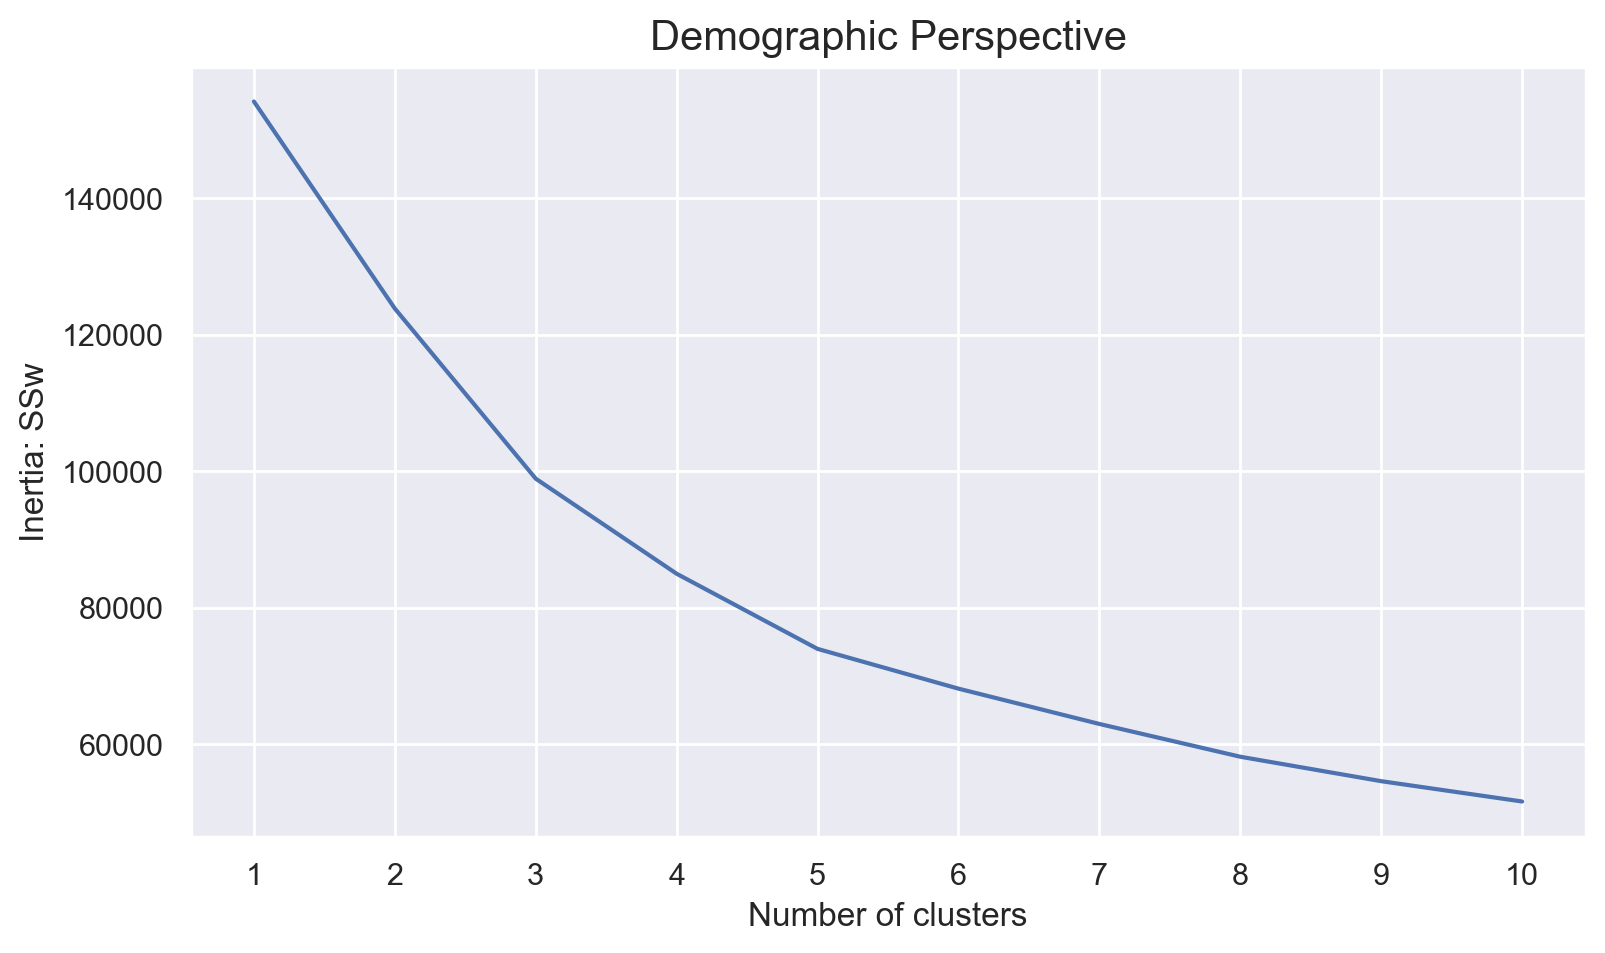

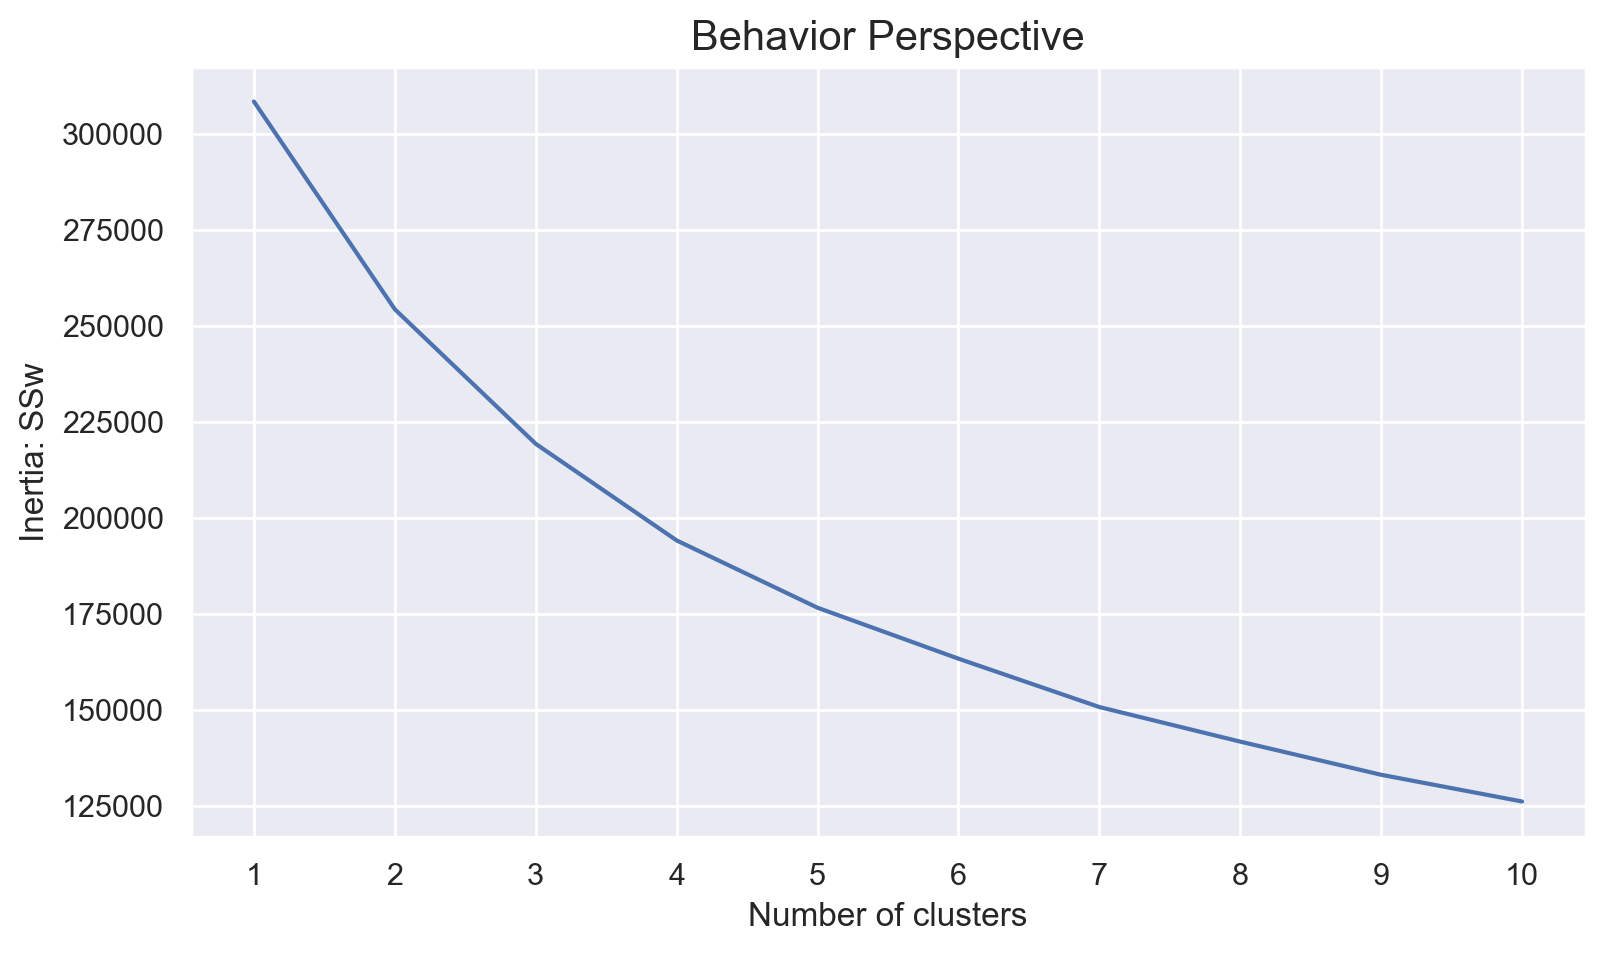

In [126]:
df_list = [df_DEMO, df_BEHAV]
perspectives_names = ["Demographic Perspective", "Behavior Perspective"]

# Iterate through DataFrames and perspectives
for data, title in zip(df_list, perspectives_names):
    range_clusters = range(1, 11)

    inertia = []
    for n_clus in range_clusters:  # iterate over desired ncluster range
        kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
        kmclust.fit(data)
        inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

    # The inertia plot

    fig, ax = plt.subplots(figsize=(9,5))

    ax.plot(range_clusters, inertia)
    ax.set_xticks(range_clusters)
    ax.set_ylabel("Inertia: SSw")
    ax.set_xlabel("Number of clusters")
    ax.set_title(title, size=15)  # Set the title to the corresponding perspective

    plt.show()


In this plot they seem around 3/4, so we will use 4 features for each perspective in the future.

## 3.2 DBSCAN Clustering <a class="anchor" id="5.2"></a>

### 3.2.1 Demographic Perspective

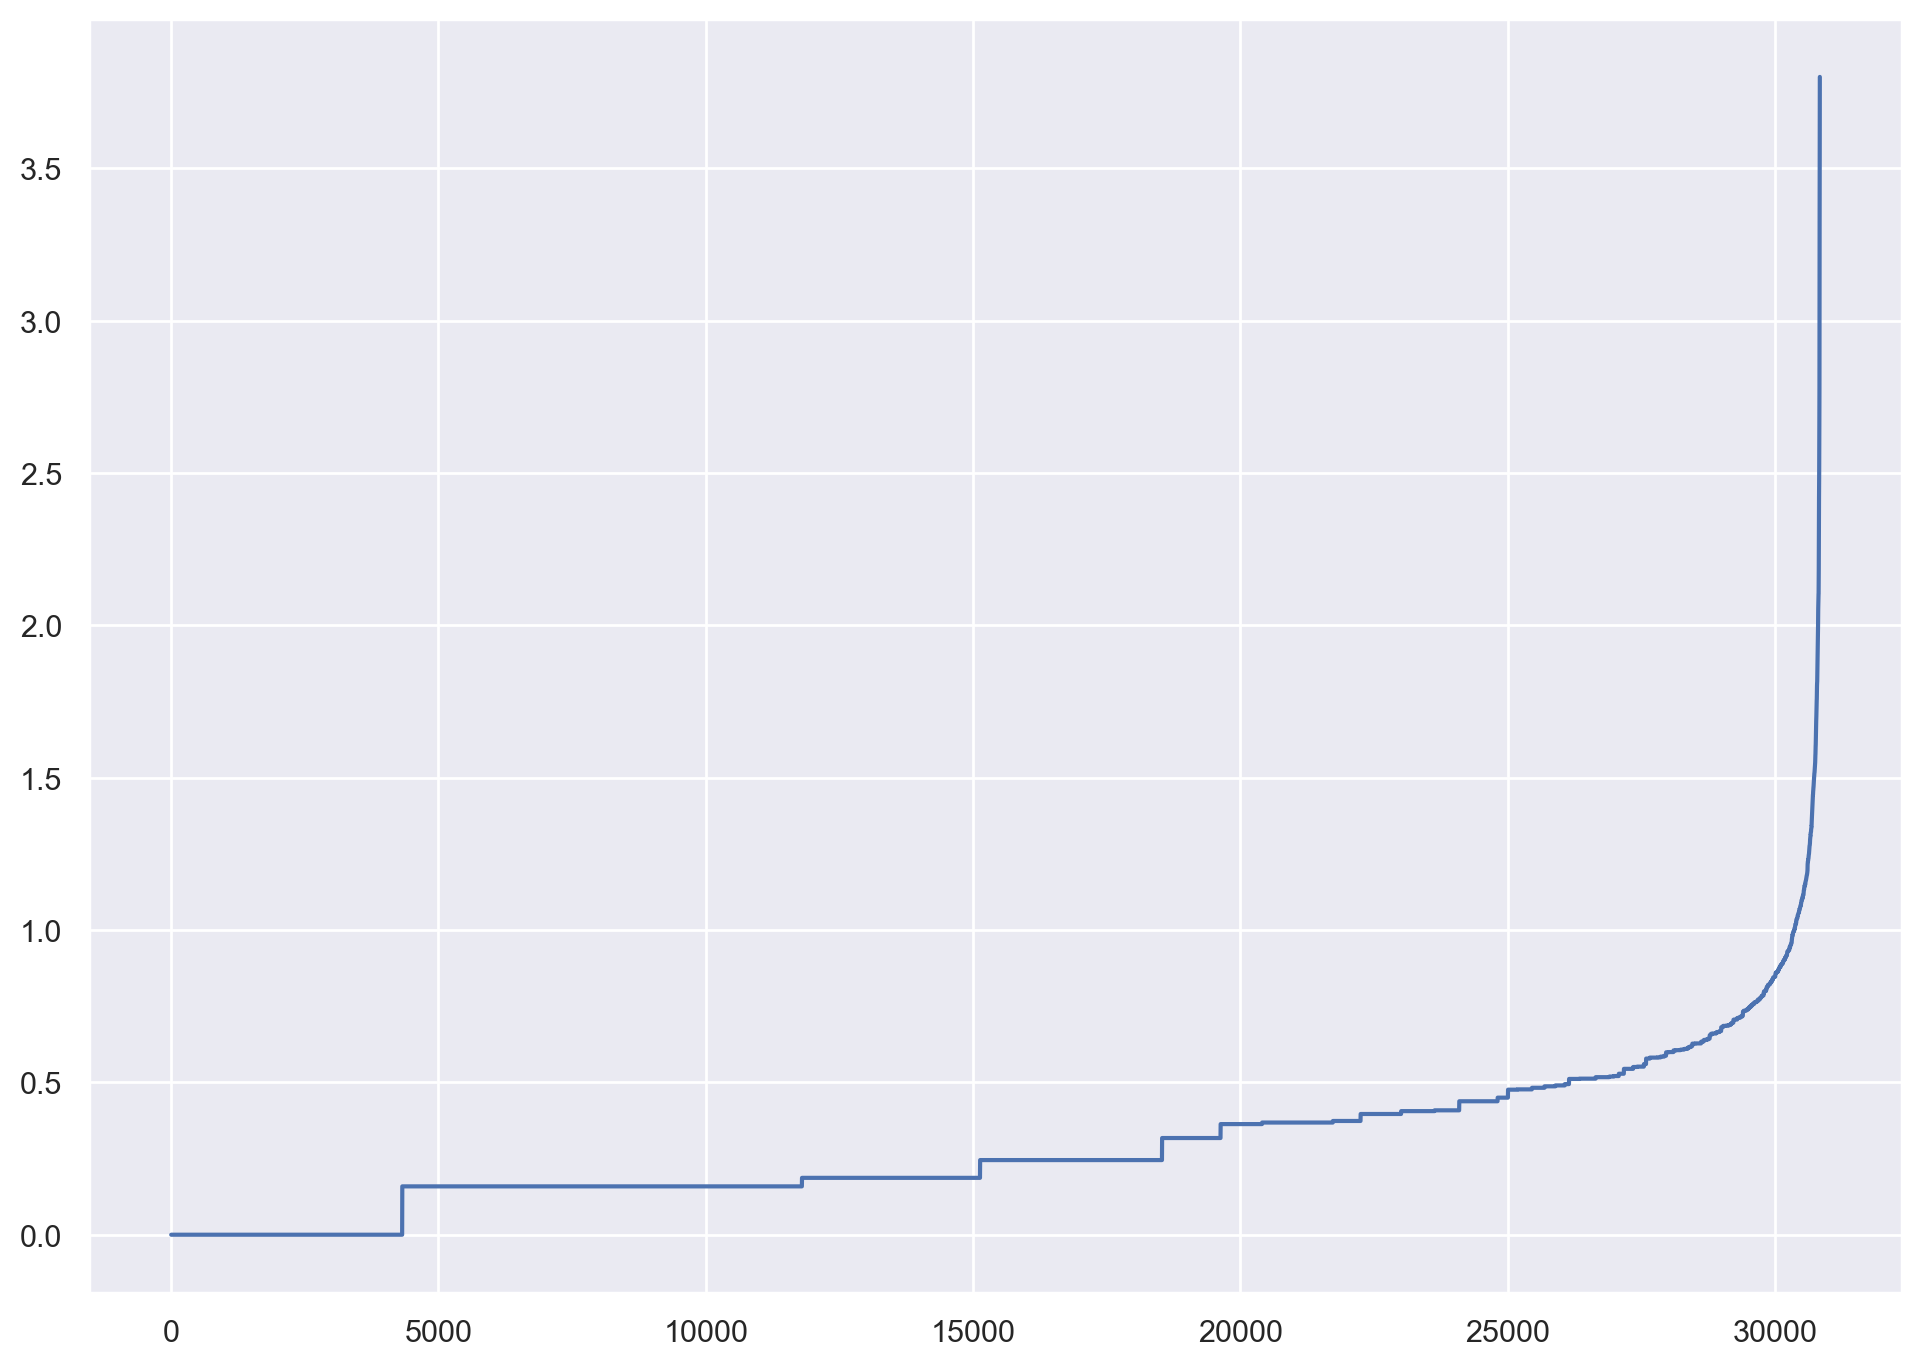

In [181]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(df_DEMO)
distances, _ = neigh.kneighbors(df_DEMO)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

The sharp rise begins around a distance value, suggesting that a suitable eps value lies in this range.

In [182]:
dbscan = DBSCAN(eps=1.2, min_samples=5, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df_DEMO)

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 4


In [183]:
df_concat = df_DEMO.copy()  # Create a copy of the original dataframe
df_concat["dbscan_labels"] = pd.Series(dbscan_labels, index=df_DEMO.index)  # Ensure index alignment
df_concat.head()

Week_days_mean  Weekend_days_mean   HR_peak  DOW_Peak  \
customer_id                                                          
1b8f824d5e        -0.445376          -0.431336  1.208591 -1.320198   
5d272b9dcb        -0.445376          -0.431336 -0.284567 -1.320198   
f6d1b2ba63        -0.445376          -0.431336 -0.471211 -1.320198   
180c632ed8        -0.445376          -0.431336 -0.097922 -0.825941   
4eb37a6705        -0.445376          -0.431336 -0.657856 -0.825941   

             customer_age  dbscan_labels  
customer_id                               
1b8f824d5e      -1.446788              0  
5d272b9dcb      -1.605453              0  
f6d1b2ba63       1.726520              0  
180c632ed8      -0.177464              0  
4eb37a6705      -1.129457              0

In [184]:
# Detecting noise (potential outliers)
df_concat.loc[df_concat['dbscan_labels'] == -1]

Week_days_mean  Weekend_days_mean   HR_peak  DOW_Peak  \
customer_id                                                          
4d43db4f0a         0.643813           6.765719  0.275367  1.645344   
eb4664b1ac         1.006876           8.115167 -0.097922  1.151087   
26fa80f66e         4.637505           6.765719 -0.097922  0.656830   
730b8daaff         4.274442           9.014799 -0.284567  0.656830   
1b178d7662         2.096065           9.914431 -0.097922  1.151087   
...                     ...                ...       ...       ...   
3b29b2d2a6         5.000568           4.066823 -1.404434  1.645344   
a9c31c0efa         7.905072           2.267560  0.462012 -0.825941   
1c4a79c101         2.459128           4.066823 -0.097922 -0.825941   
d0448942d4         4.637505          10.814063 -0.097922  1.151087   
cc499f3531         2.459128           7.665351  1.581880  1.645344   

             customer_age  dbscan_labels  
customer_id                               
4d43db4f0a       1.091859             -1  
eb4664b1ac       1.885186             -1  
26fa80f66e      -0.336130             -1  
730b8daaff       0.933193             -1  
1b178d7662      -0.812126             -1  
...                   ...            ...  
3b29b2d2a6       2.837178             -1  
a9c31c0efa      -0.018799             -1  
1c4a79c101       1.567855             -1  
d0448942d4      -0.970791             -1  
cc499f3531      -0.018799             -1  

[126 rows x 6 columns]

In [185]:
# Computing the R^2 of the cluster solution
df_nonoise = df_concat.loc[df_concat['dbscan_labels'] != -1]
sst = get_ss(df_DEMO)  # get total sum of squares
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.0671


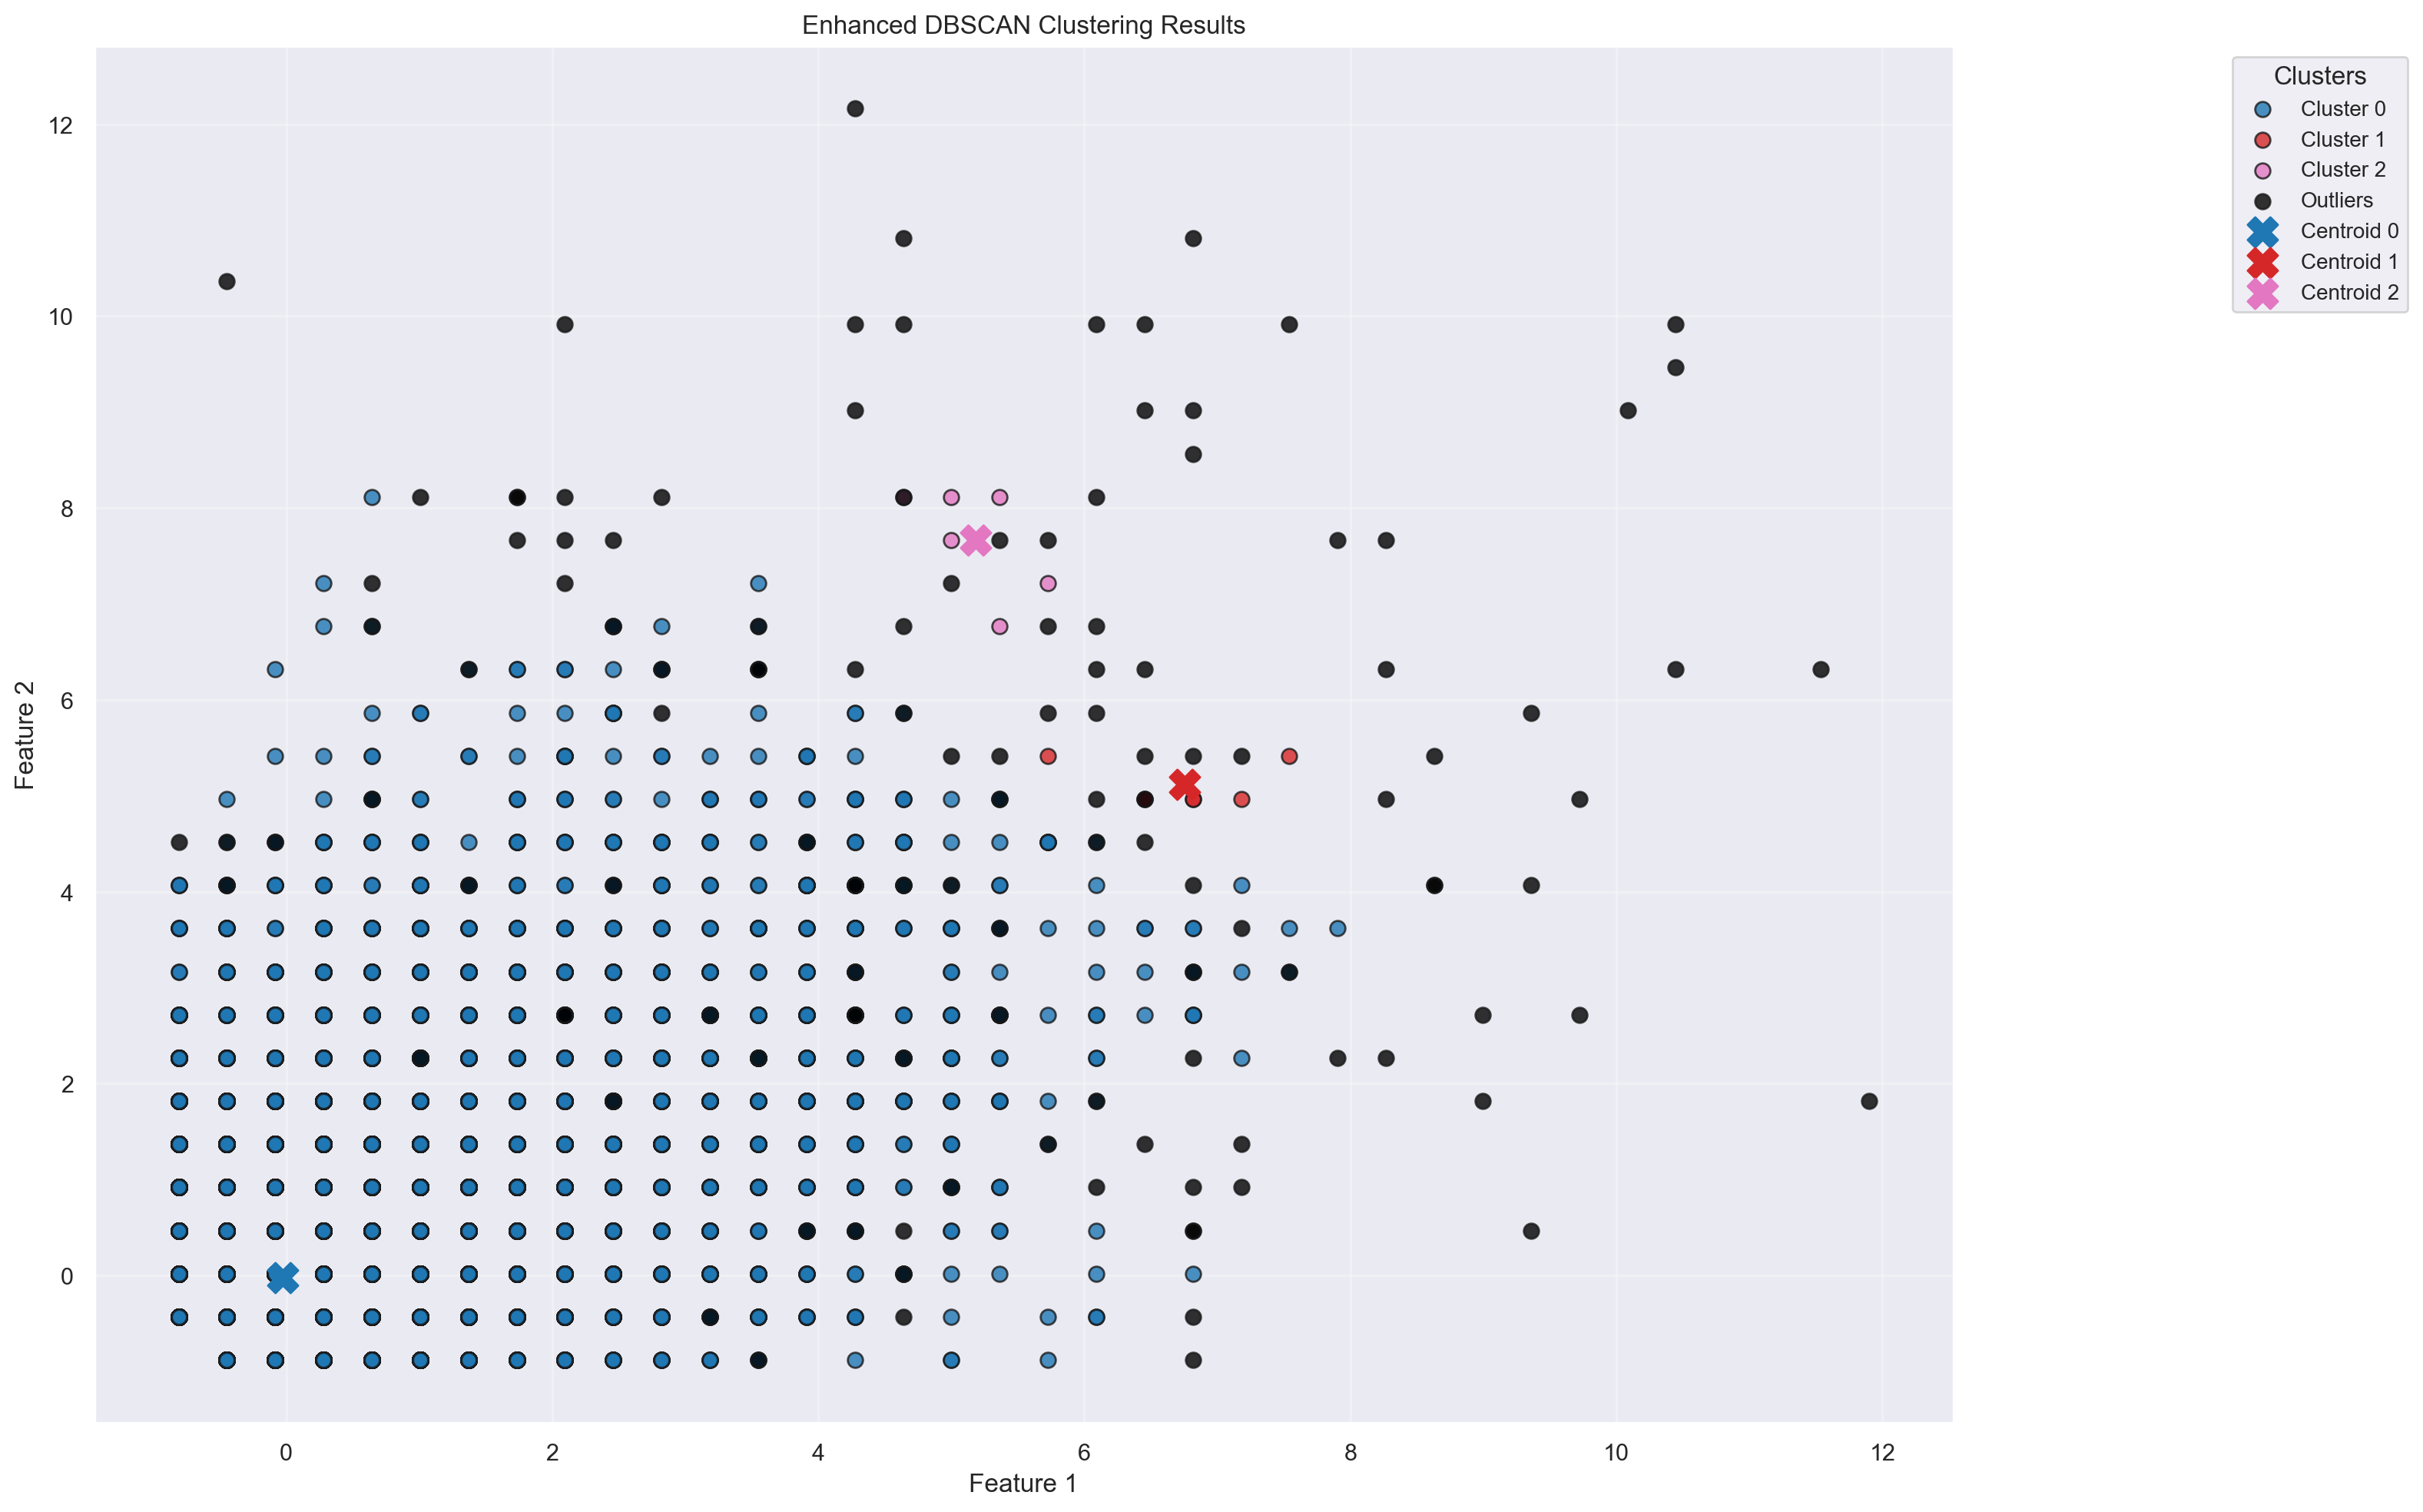

In [186]:
unique_labels = set(dbscan_labels)
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Exclude noise label (-1)
assert num_clusters >= 3, "DBSCAN found fewer than 3 clusters. Adjust DBSCAN parameters."

# Define a color palette
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))  # Tab10 provides more visually distinct colors
cluster_colors = {label: colors[i] for i, label in enumerate(unique_labels)}

plt.figure(figsize=(16, 10))

# Plot each cluster with a corresponding color
for label in unique_labels:
    color = cluster_colors[label]
    if label == -1:  # Outliers
        color = [0, 0, 0, 1]  # Black for outliers
    subset = df_DEMO[dbscan_labels == label]
    plt.scatter(subset.iloc[:, 0], subset.iloc[:, 1],  # First two dimensions
                s=50, c=[color], label=f"Cluster {label}" if label != -1 else "Outliers", alpha=0.8, edgecolor='k')

# Add cluster centroids
for label in unique_labels:
    if label != -1:  # Skip outliers
        cluster_points = df_DEMO[dbscan_labels == label]
        centroid = cluster_points.mean(axis=0)
        plt.scatter(centroid[0], centroid[1], c=[cluster_colors[label]], marker='X', s=200, label=f"Centroid {label}")

plt.title("Enhanced DBSCAN Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1), title="Clusters", fontsize="small")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

A clustering solution with R² = 0.0671 indicates that the clusters account for a relatively small proportion of the variance in the dataset, suggesting low separability among clusters.

Given the initial number of clusters, and the previous results, we can affirm that DBSCAN is not the most appropriate clustering method for this perspective.

### 3.2.2 Behavioral Perspective

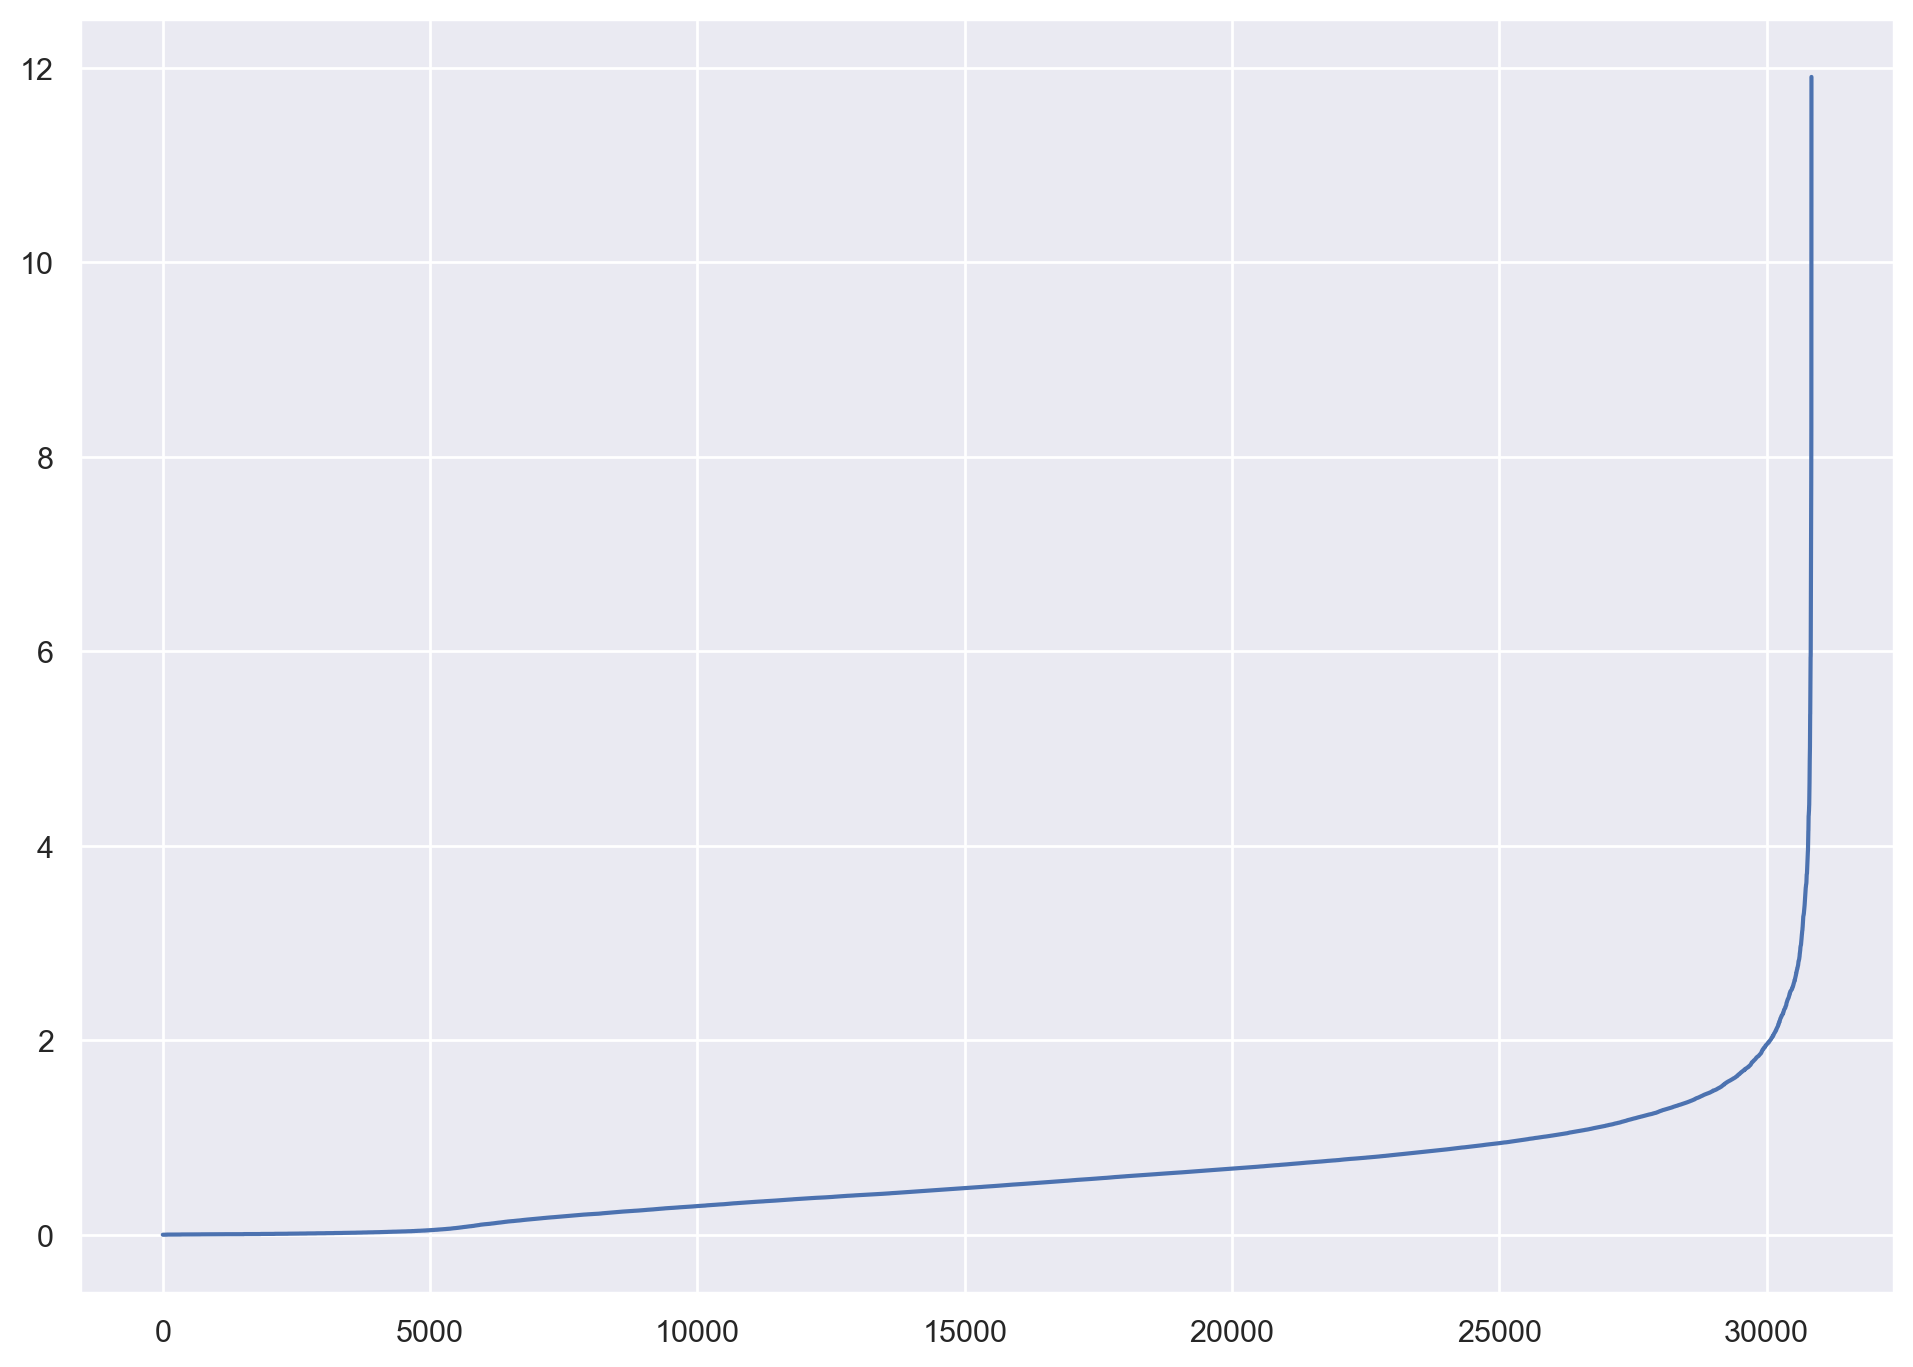

In [187]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(df_BEHAV)
distances, _ = neigh.kneighbors(df_BEHAV)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [188]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.8, min_samples=10, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df_BEHAV)

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 5


In [189]:
df_concat = df_BEHAV.copy()  # Create a copy of the original dataframe
df_concat["dbscan_labels"] = pd.Series(dbscan_labels, index=df_BEHAV.index)  # Ensure index alignment
df_concat.head()

CUI_American  CUI_Italian  CUI_Asian  CUI_OTHER  \
customer_id                                                    
1b8f824d5e      -0.456579     -0.31153   0.453449  -0.594483   
5d272b9dcb       0.813936     -0.31153  -0.397661  -0.594483   
f6d1b2ba63       0.455179     -0.31153  -0.639483  -0.594483   
180c632ed8      -0.456579     -0.31153   0.554871  -0.594483   
4eb37a6705       0.987368     -0.31153   0.907197  -0.594483   

             Chain_Preference  Order_Frequency  Avg_Spend_per_Order  \
customer_id                                                           
1b8f824d5e          -0.331571         1.561888             0.536321   
5d272b9dcb           0.960027         1.561888            -0.082694   
f6d1b2ba63           0.960027         1.561888            -0.723473   
180c632ed8          -0.331571         0.757988             0.707879   
4eb37a6705          -1.623169         0.757988             2.236531   

             Product_per_Order  Total_Orders  Customer_Duration  dbscan_labels  
customer_id                                                                     
1b8f824d5e            2.912290     -0.506478          -1.170403              0  
5d272b9dcb           -0.715329     -0.506478          -1.170403              0  
f6d1b2ba63           -0.715329     -0.506478          -1.170403              0  
180c632ed8            0.493877     -0.506478          -1.136119              0  
4eb37a6705            2.912290     -0.506478          -1.136119              0

In [190]:
# Detecting noise (potential outliers)
df_concat.loc[df_concat['dbscan_labels'] == -1]

CUI_American  CUI_Italian  CUI_Asian  CUI_OTHER  \
customer_id                                                    
4d43db4f0a       7.907813     0.687097  -0.062742  -0.594483   
d6e5be6382       7.773031     1.190937  -0.639483  -0.267490   
928baa4e96       6.632342     1.827524   2.118581  -0.594483   
01ad9867f2       0.705913    -0.311530  10.225126   2.573385   
63953d4795       0.102368    -0.311530   3.140367   5.398012   
...                   ...          ...        ...        ...   
8122bbcb54       3.405510    -0.311530  -0.639483  -0.594483   
c847c37d96      -0.456579    -0.311530   2.181024  -0.594483   
98ff666b8e      -0.456579    -0.311530   1.707596  -0.594483   
0777806a99      -0.456579    -0.069164   0.187028  -0.594483   
0a786af79c      -0.456579    -0.311530  -0.639483   1.406062   

             Chain_Preference  Order_Frequency  Avg_Spend_per_Order  \
customer_id                                                           
4d43db4f0a           0.837018         0.327995            -0.644401   
d6e5be6382          -0.885113         0.163102            -0.675798   
928baa4e96           0.221971        -0.235925             0.202717   
01ad9867f2           0.443388        -0.032286             0.999846   
63953d4795          -0.132863         0.195258            -0.211657   
...                       ...              ...                  ...   
8122bbcb54           0.960027         1.561888             3.676845   
c847c37d96           0.960027         3.973589             3.458558   
98ff666b8e          -1.623169         1.561888             6.627888   
0777806a99           0.314228         8.796990            -0.536232   
0a786af79c          -0.762103         6.385289             0.369031   

             Product_per_Order  Total_Orders  Customer_Duration  dbscan_labels  
customer_id                                                                     
4d43db4f0a            0.090808      3.896401           0.235218             -1  
d6e5be6382           -0.254679      3.896401           0.475203             -1  
928baa4e96            0.839365      2.274287           0.646620             -1  
01ad9867f2            0.735718      3.664670           0.783754             -1  
63953d4795           -0.436282      5.055053           0.818037             -1  
...                        ...           ...                ...            ...  
8122bbcb54            4.121496     -0.738209          -1.204686             -1  
c847c37d96            2.912290     -0.506478          -1.204686             -1  
98ff666b8e            6.539909     -0.738209          -1.204686             -1  
0777806a99           -0.715329     -0.043017          -1.204686             -1  
0a786af79c            0.896946     -0.274748          -1.204686             -1  

[577 rows x 11 columns]

In [191]:
# Computing the R^2 of the cluster solution
df_nonoise = df_concat.loc[df_concat['dbscan_labels'] != -1]
sst = get_ss(df_BEHAV)  # get total sum of squares
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.1913


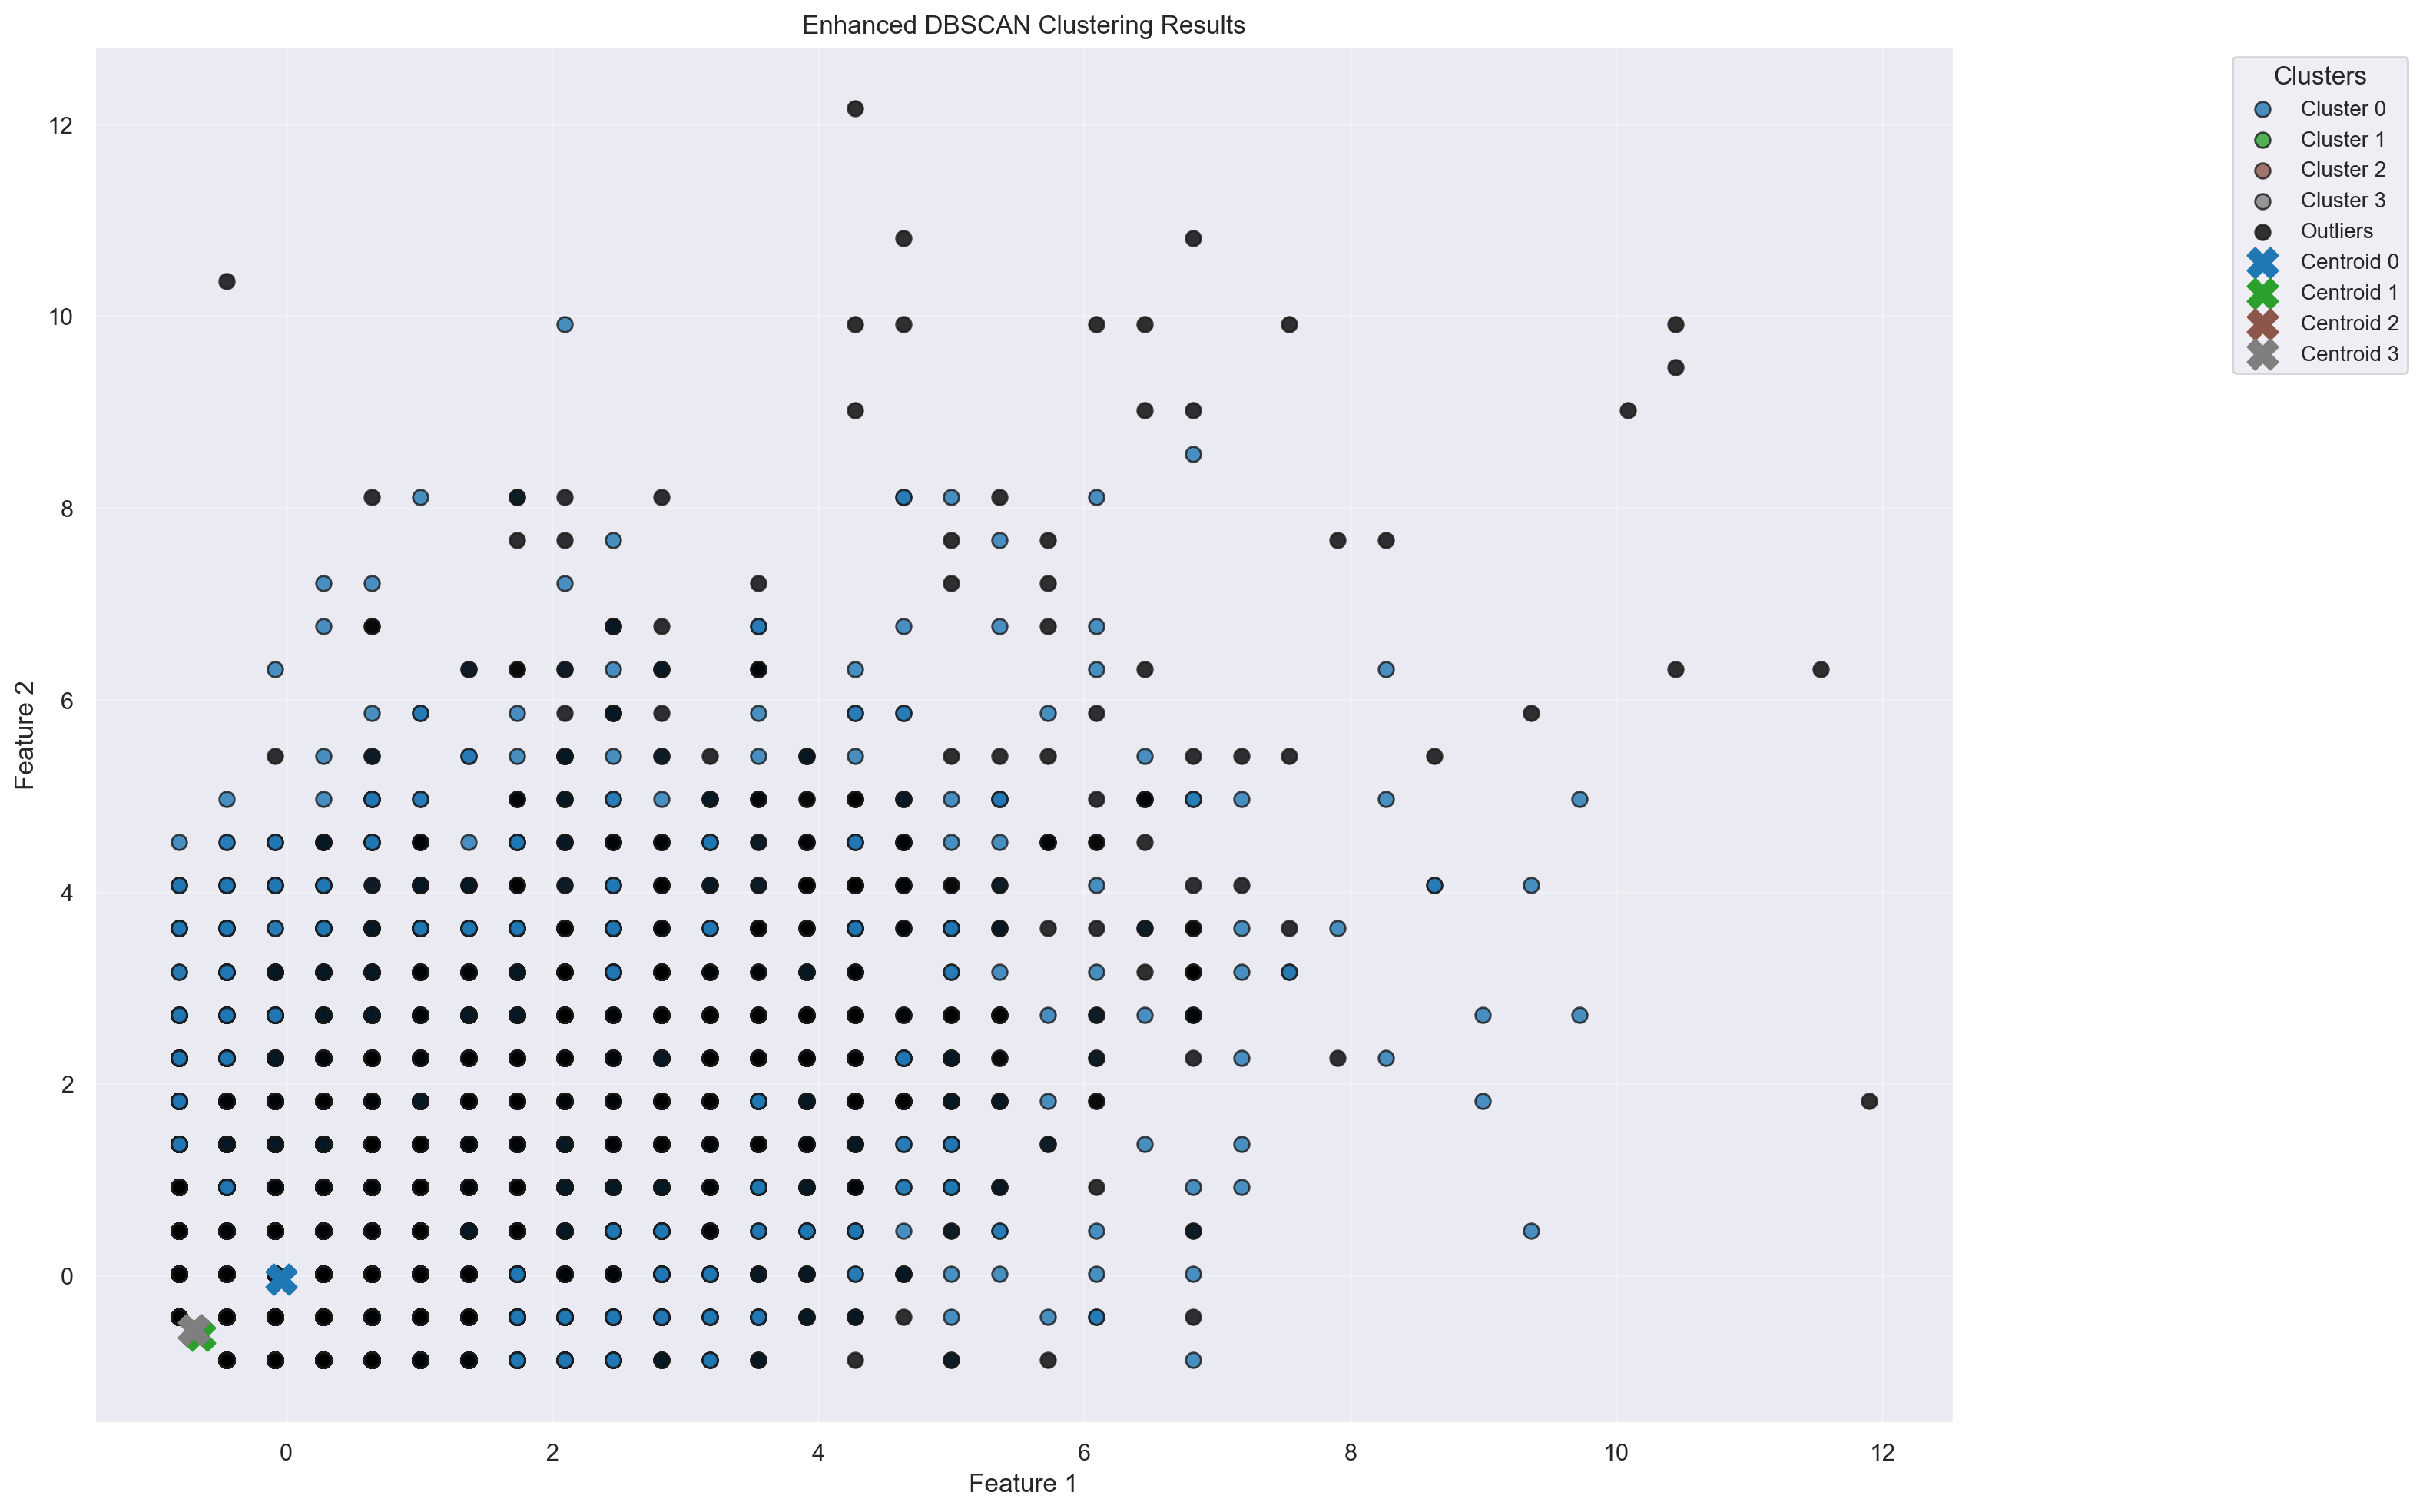

In [192]:
unique_labels = set(dbscan_labels)
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Exclude noise label (-1)
assert num_clusters >= 3, "DBSCAN found fewer than 4 clusters. Adjust DBSCAN parameters."

# Define a color palette
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))  # Tab10 provides more visually distinct colors
cluster_colors = {label: colors[i] for i, label in enumerate(unique_labels)}

plt.figure(figsize=(16, 10))

# Plot each cluster with a corresponding color
for label in unique_labels:
    color = cluster_colors[label]
    if label == -1:  # Outliers
        color = [0, 0, 0, 1]  # Black for outliers
    subset = df_DEMO[dbscan_labels == label]
    plt.scatter(subset.iloc[:, 0], subset.iloc[:, 1],  # First two dimensions
                s=50, c=[color], label=f"Cluster {label}" if label != -1 else "Outliers", alpha=0.8, edgecolor='k')

# Add cluster centroids
for label in unique_labels:
    if label != -1:  # Skip outliers
        cluster_points = df_DEMO[dbscan_labels == label]
        centroid = cluster_points.mean(axis=0)
        plt.scatter(centroid[0], centroid[1], c=[cluster_colors[label]], marker='X', s=200, label=f"Centroid {label}")

plt.title("Enhanced DBSCAN Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1), title="Clusters", fontsize="small")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The cluster solution achieved an R² value of 0.1913, indicating that 19.13% of the variance in the dataset is explained by the 4 identified clusters.

## 3.3  Mean-Shift Clustering

* Demographic Perspective

In [193]:
bandwidth = estimate_bandwidth(df_DEMO, quantile=0.38, random_state=1, n_jobs=-1)
bandwidth

2.5254049380745283

In [194]:
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
ms_labels = ms.fit_predict(df_DEMO)

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 5


In [195]:
# Concatenating the labels to df
df_concat = df_DEMO.copy()  # Create a copy of the original dataframe
df_concat["ms_labels"] = pd.Series(ms_labels, index=df_DEMO.index)  # Ensure index alignment
df_concat.head()

Week_days_mean  Weekend_days_mean   HR_peak  DOW_Peak  \
customer_id                                                          
1b8f824d5e        -0.445376          -0.431336  1.208591 -1.320198   
5d272b9dcb        -0.445376          -0.431336 -0.284567 -1.320198   
f6d1b2ba63        -0.445376          -0.431336 -0.471211 -1.320198   
180c632ed8        -0.445376          -0.431336 -0.097922 -0.825941   
4eb37a6705        -0.445376          -0.431336 -0.657856 -0.825941   

             customer_age  ms_labels  
customer_id                           
1b8f824d5e      -1.446788          0  
5d272b9dcb      -1.605453          0  
f6d1b2ba63       1.726520          0  
180c632ed8      -0.177464          0  
4eb37a6705      -1.129457          0

In [196]:
# Computing the R^2 of the cluster solution
sst = get_ss(df_DEMO)  # get total sum of squares
ssw_labels = df_concat.groupby(by='ms_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.0945


* Behavioral Perspective

In [197]:
bandwidth = estimate_bandwidth(df_BEHAV, quantile=0.8, random_state=1, n_jobs=-1)
bandwidth

4.8216565231644495

In [198]:
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
ms_labels = ms.fit_predict(df_BEHAV)

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 6


In [199]:
# Concatenating the labels to df
df_concat = df_BEHAV.copy()  # Create a copy of the original dataframe
df_concat["ms_labels"] = pd.Series(ms_labels, index=df_BEHAV.index)  # Ensure index alignment
df_concat.head()

CUI_American  CUI_Italian  CUI_Asian  CUI_OTHER  \
customer_id                                                    
1b8f824d5e      -0.456579     -0.31153   0.453449  -0.594483   
5d272b9dcb       0.813936     -0.31153  -0.397661  -0.594483   
f6d1b2ba63       0.455179     -0.31153  -0.639483  -0.594483   
180c632ed8      -0.456579     -0.31153   0.554871  -0.594483   
4eb37a6705       0.987368     -0.31153   0.907197  -0.594483   

             Chain_Preference  Order_Frequency  Avg_Spend_per_Order  \
customer_id                                                           
1b8f824d5e          -0.331571         1.561888             0.536321   
5d272b9dcb           0.960027         1.561888            -0.082694   
f6d1b2ba63           0.960027         1.561888            -0.723473   
180c632ed8          -0.331571         0.757988             0.707879   
4eb37a6705          -1.623169         0.757988             2.236531   

             Product_per_Order  Total_Orders  Customer_Duration  ms_labels  
customer_id                                                                 
1b8f824d5e            2.912290     -0.506478          -1.170403          0  
5d272b9dcb           -0.715329     -0.506478          -1.170403          0  
f6d1b2ba63           -0.715329     -0.506478          -1.170403          0  
180c632ed8            0.493877     -0.506478          -1.136119          0  
4eb37a6705            2.912290     -0.506478          -1.136119          0

In [200]:
# Computing the R^2 of the cluster solution
sst = get_ss(df_BEHAV)  # get total sum of squares
ssw_labels = df_concat.groupby(by='ms_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.0786


In order to reduce the number of clusters, we had to raise the value of quantile, to merge nearby clusters into fewer groups. This resulted in an unsatisfying result of R^2 (Demographic: ~9.45% and Behavioral: ~7.86%) for both perspectives.

## 3.4 Gaussian Mixture Model (GMM)

* Demographic Perspective

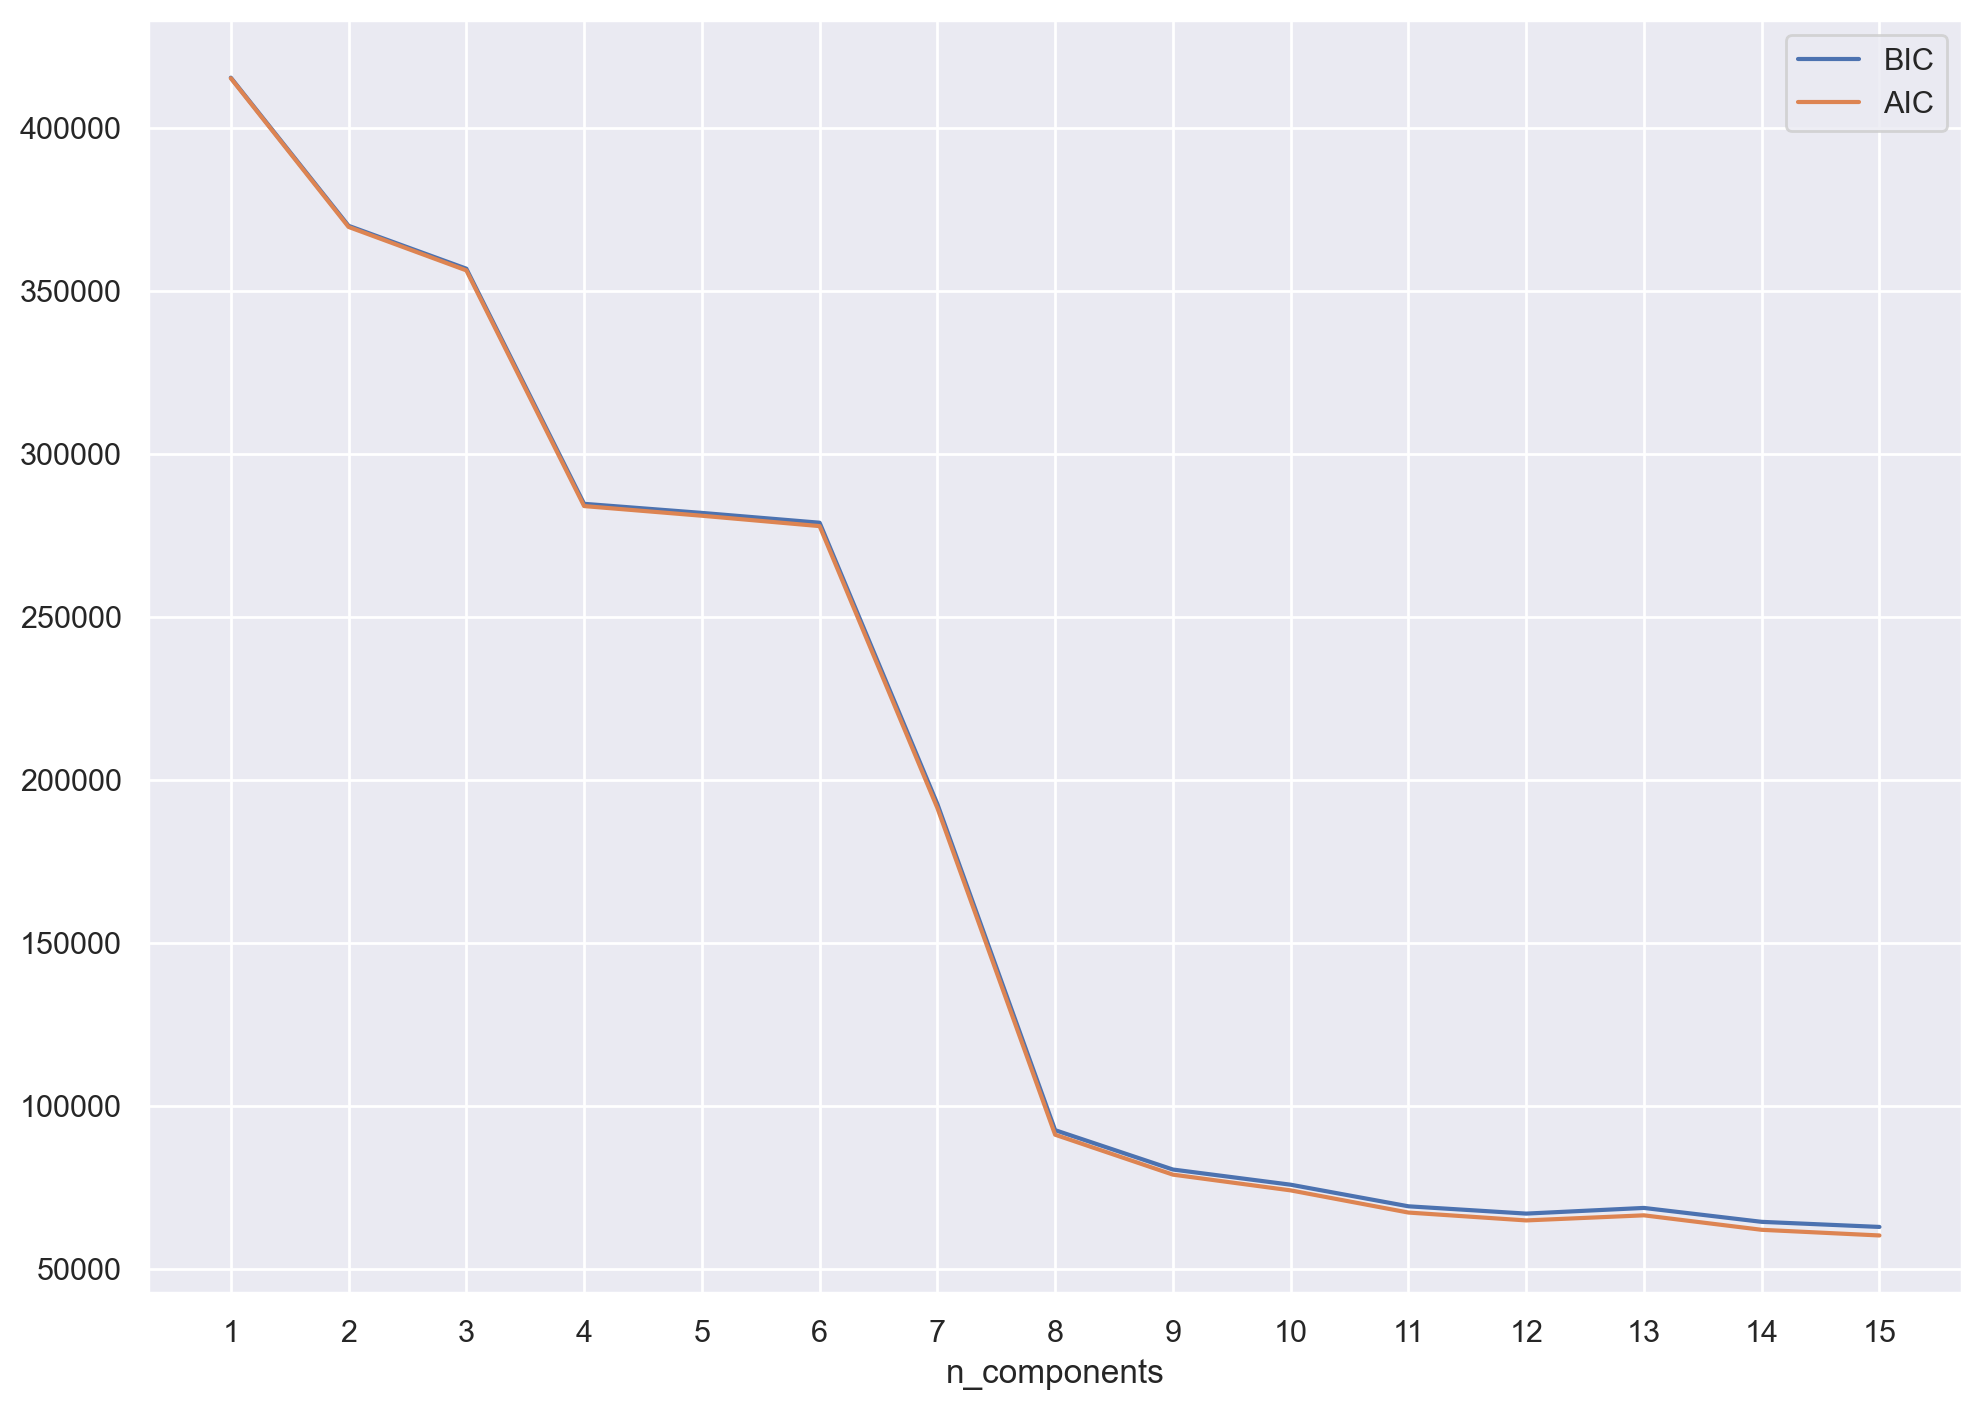

In [205]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_DEMO)
          for n in n_components]

bic_values = [m.bic(df_DEMO) for m in models]
aic_values = [m.aic(df_DEMO) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [207]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=8, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_DEMO)

In [208]:
df_concat = df_DEMO.copy()  # Create a copy of the original dataframe
df_concat["gmm_labels"] = pd.Series(gmm_labels, index=df_DEMO.index)  # Ensure index alignment
df_concat.head()

Week_days_mean  Weekend_days_mean   HR_peak  DOW_Peak  \
customer_id                                                          
1b8f824d5e        -0.445376          -0.431336  1.208591 -1.320198   
5d272b9dcb        -0.445376          -0.431336 -0.284567 -1.320198   
f6d1b2ba63        -0.445376          -0.431336 -0.471211 -1.320198   
180c632ed8        -0.445376          -0.431336 -0.097922 -0.825941   
4eb37a6705        -0.445376          -0.431336 -0.657856 -0.825941   

             customer_age  gmm_labels  
customer_id                            
1b8f824d5e      -1.446788           4  
5d272b9dcb      -1.605453           4  
f6d1b2ba63       1.726520           4  
180c632ed8      -0.177464           4  
4eb37a6705      -1.129457           4

In [209]:
# Computing the R^2 of the cluster solution
sst = get_ss(df_DEMO)  # get total sum of squares
ssw_labels = df_concat.groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.3357


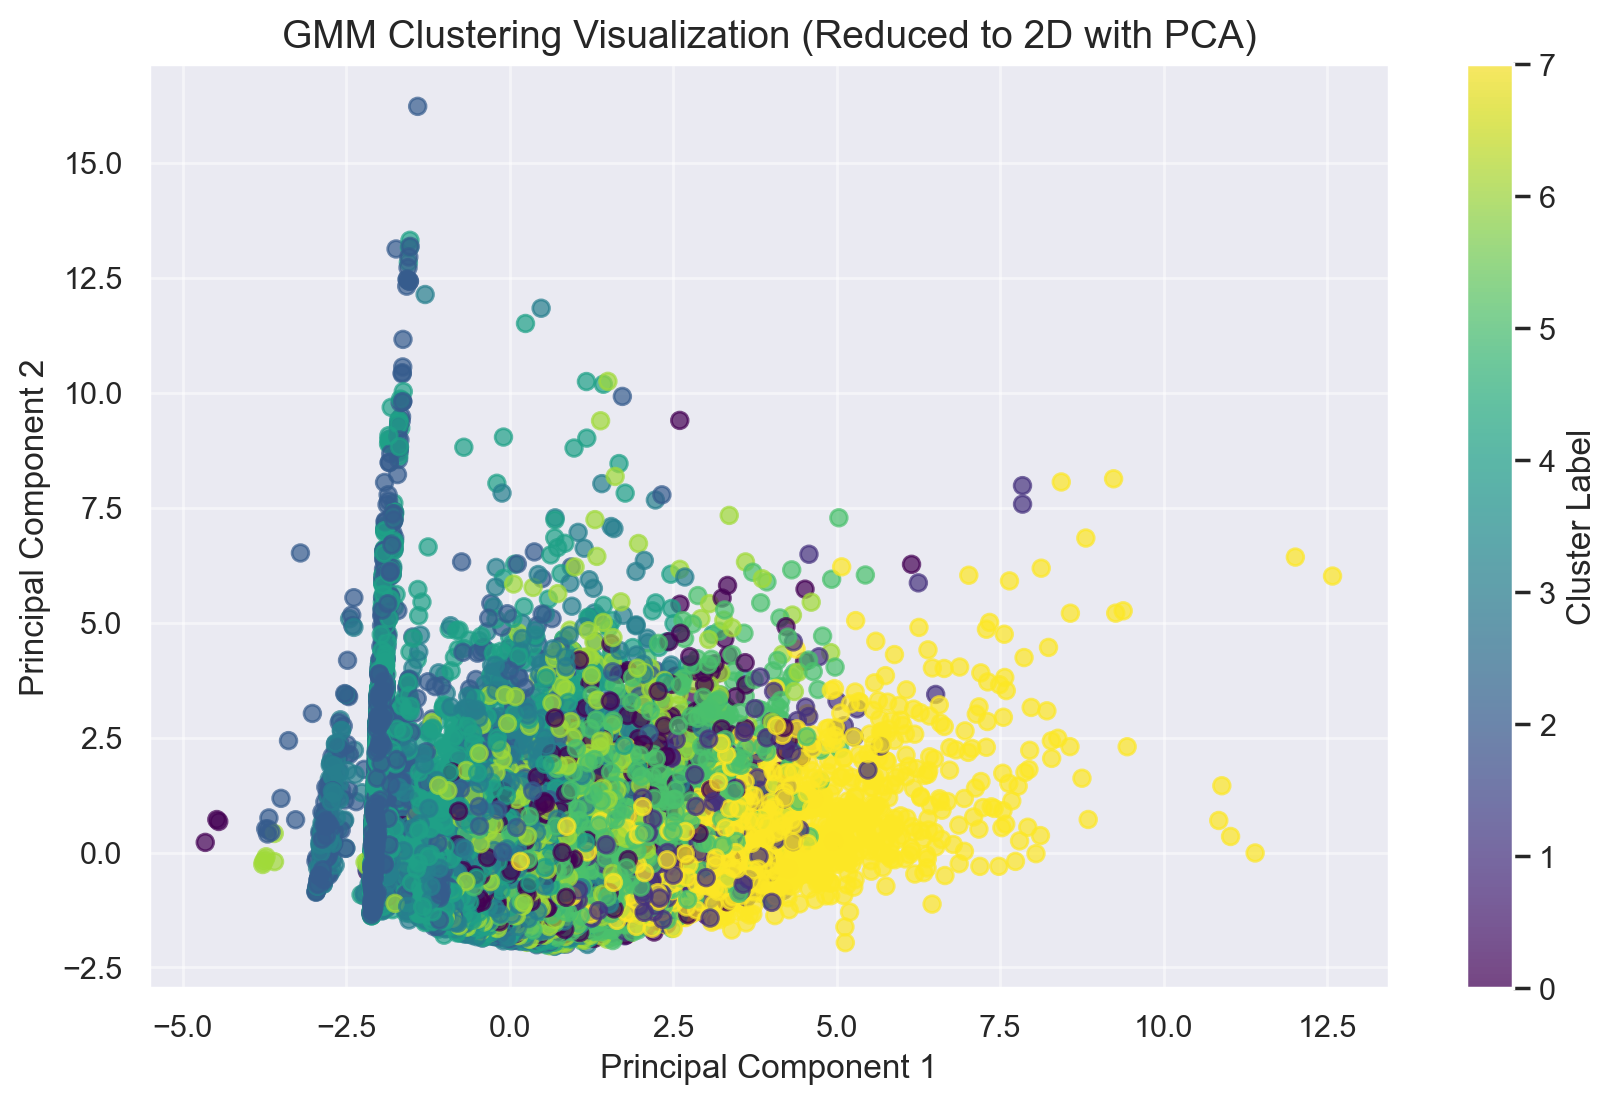

In [210]:
# Reducing dimensionality for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_BEHAV)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=gmm_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Cluster Label")
plt.title('GMM Clustering Visualization (Reduced to 2D with PCA)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

* Behavioral Perspective

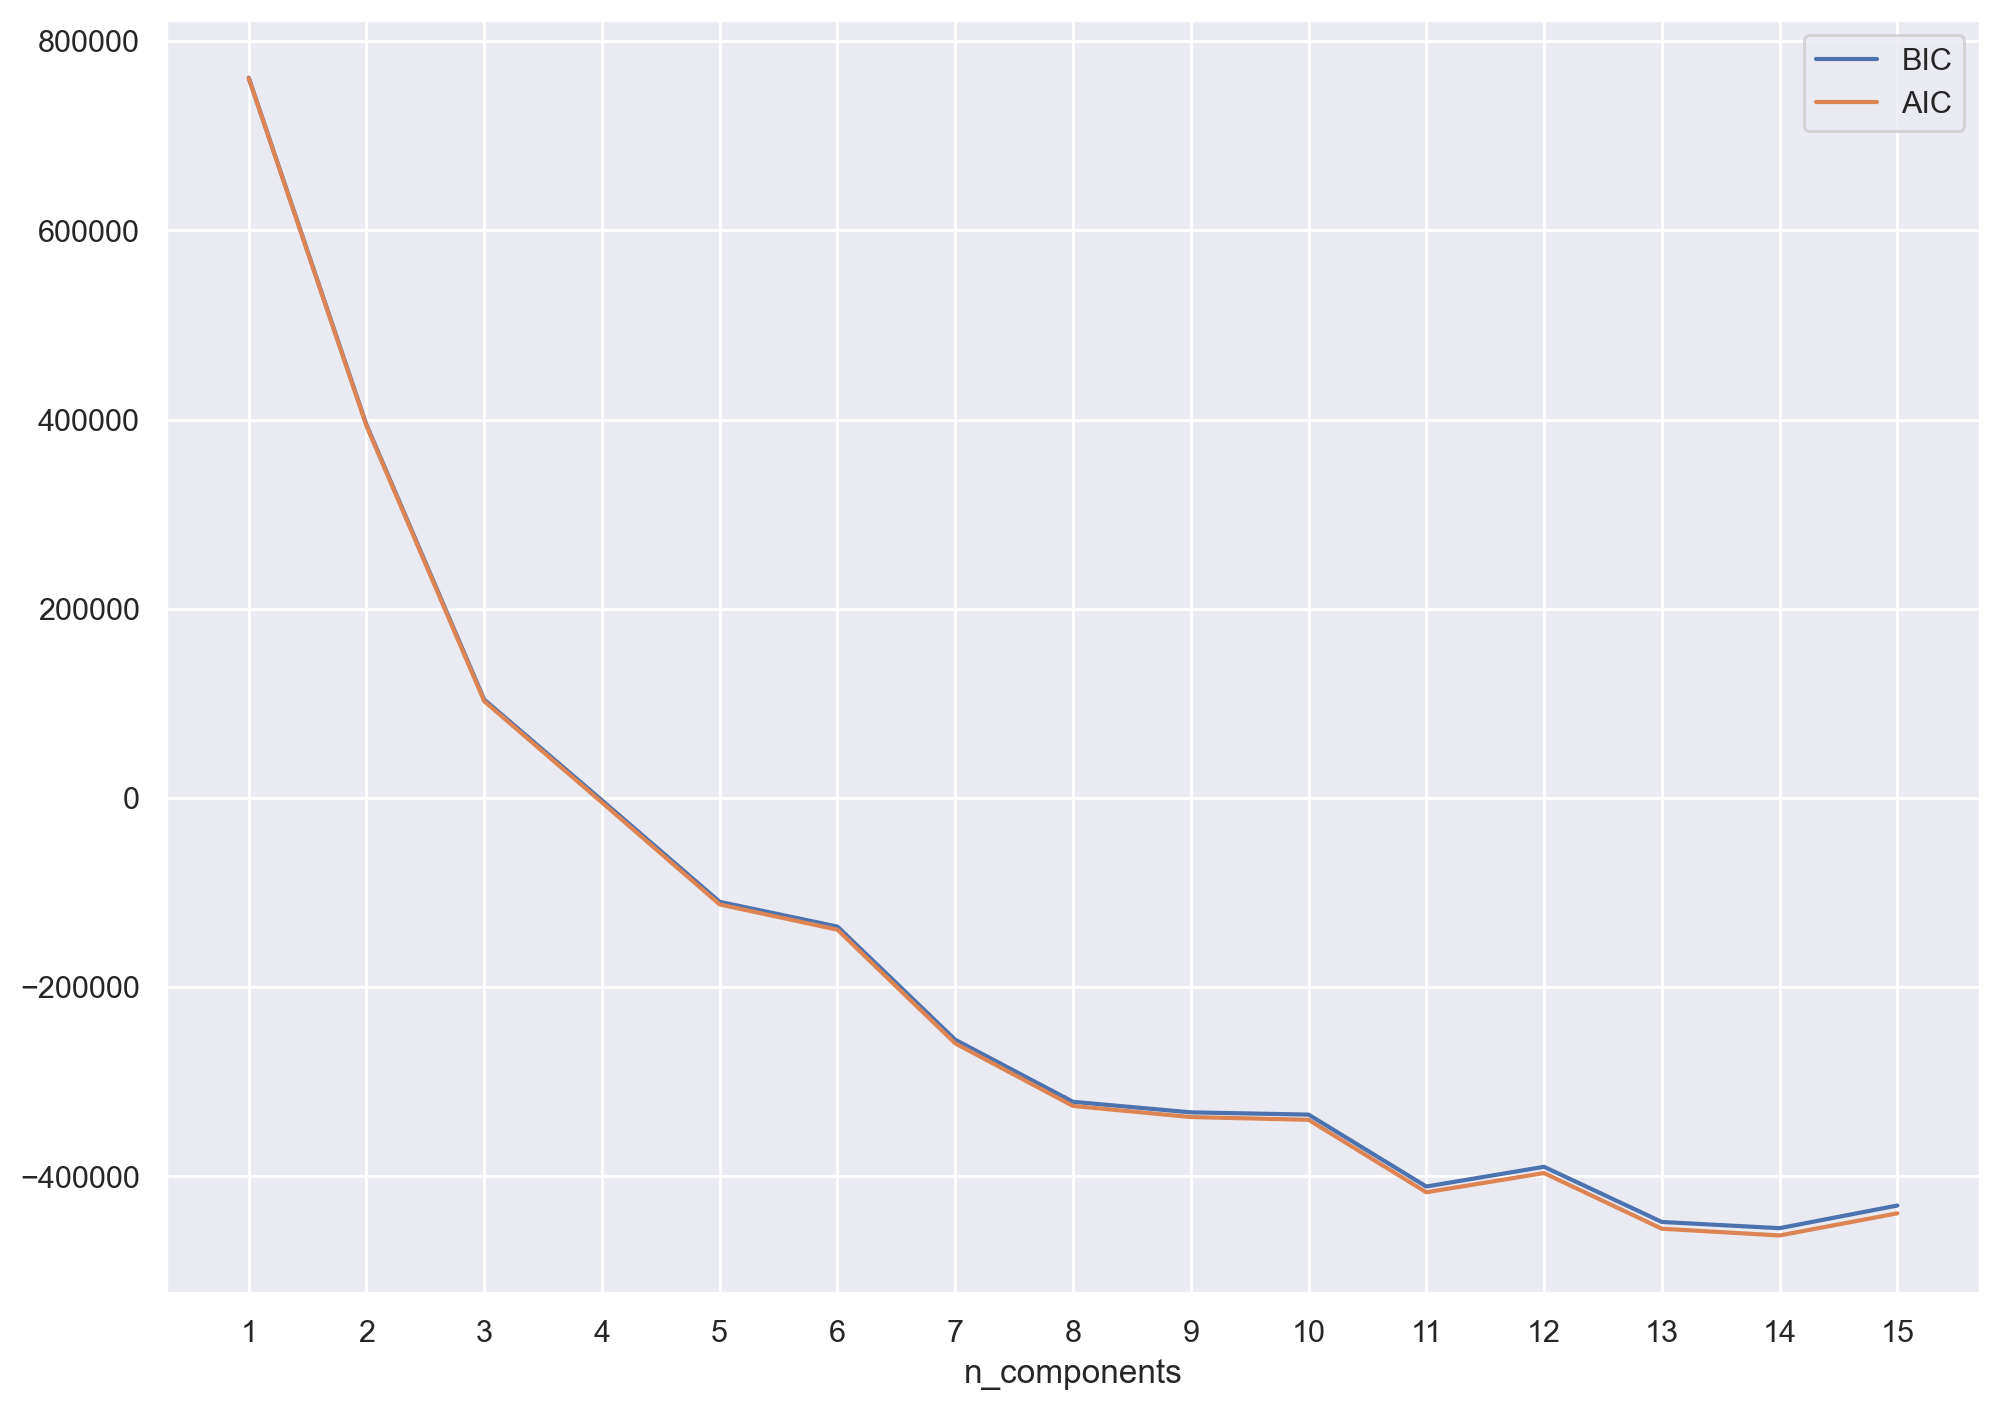

In [212]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_BEHAV)
          for n in n_components]

bic_values = [m.bic(df_BEHAV) for m in models]
aic_values = [m.aic(df_BEHAV) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

Graph suggests 7 to 8 components.

In [220]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=7, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_BEHAV)

In [221]:
df_concat = df_BEHAV.copy()  # Create a copy of the original dataframe
df_concat["gmm_labels"] = pd.Series(gmm_labels, index=df_BEHAV.index)  # Ensure index alignment
df_concat.head()

CUI_American  CUI_Italian  CUI_Asian  CUI_OTHER  \
customer_id                                                    
1b8f824d5e      -0.456579     -0.31153   0.453449  -0.594483   
5d272b9dcb       0.813936     -0.31153  -0.397661  -0.594483   
f6d1b2ba63       0.455179     -0.31153  -0.639483  -0.594483   
180c632ed8      -0.456579     -0.31153   0.554871  -0.594483   
4eb37a6705       0.987368     -0.31153   0.907197  -0.594483   

             Chain_Preference  Order_Frequency  Avg_Spend_per_Order  \
customer_id                                                           
1b8f824d5e          -0.331571         1.561888             0.536321   
5d272b9dcb           0.960027         1.561888            -0.082694   
f6d1b2ba63           0.960027         1.561888            -0.723473   
180c632ed8          -0.331571         0.757988             0.707879   
4eb37a6705          -1.623169         0.757988             2.236531   

             Product_per_Order  Total_Orders  Customer_Duration  gmm_labels  
customer_id                                                                  
1b8f824d5e            2.912290     -0.506478          -1.170403           1  
5d272b9dcb           -0.715329     -0.506478          -1.170403           1  
f6d1b2ba63           -0.715329     -0.506478          -1.170403           1  
180c632ed8            0.493877     -0.506478          -1.136119           1  
4eb37a6705            2.912290     -0.506478          -1.136119           1

In [223]:
# Computing the R^2 of the cluster solution
sst = get_ss(df_BEHAV)  # get total sum of squares
ssw_labels = df_concat.groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.3314


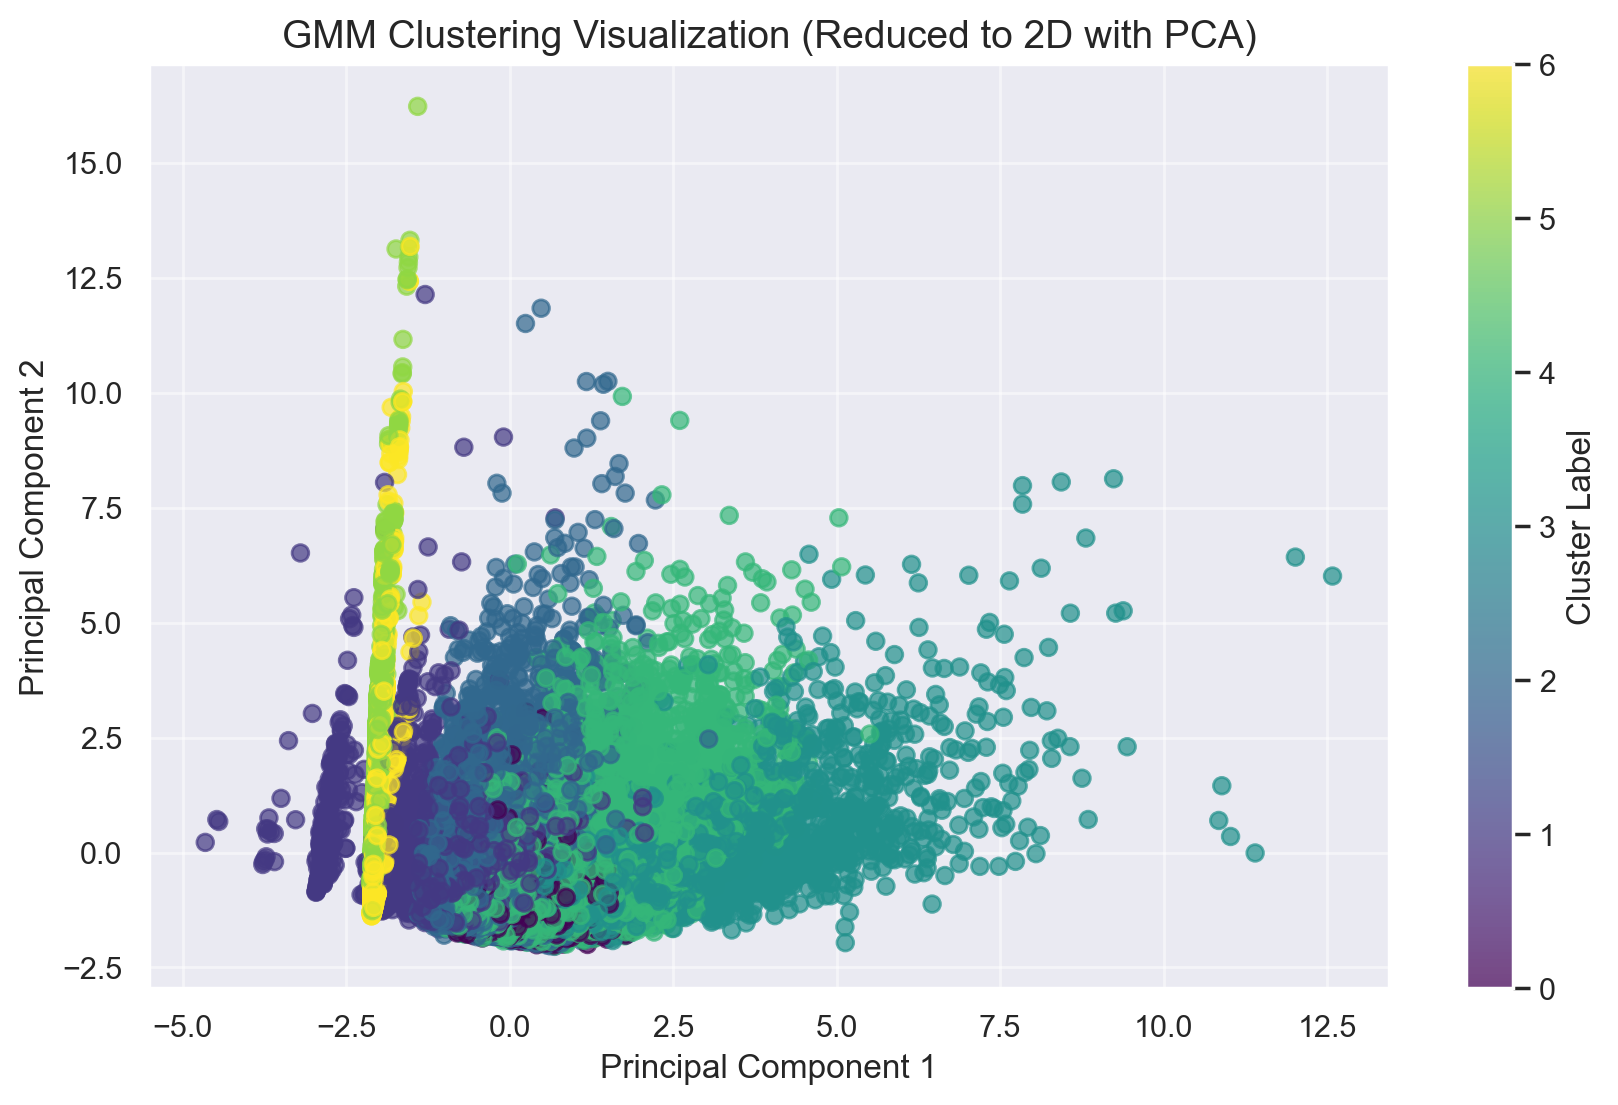

In [224]:
# Reducing dimensionality for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_BEHAV)

# Creating a scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=gmm_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Cluster Label")
plt.title('GMM Clustering Visualization (Reduced to 2D with PCA)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

# 4. Final clustering with merged perspectives

The technique with the highest R2 score is by far K-means, for both perspectives. We will use K-means for clustering and merge the results for each perspective. We will merge the lowest frequency clusters with their most similar.

* Starting K-means clustering

In [153]:
# First, apply KMeans clustering and assign behavior_labels and demographic_labels
kmeans_BEHAV = KMeans(
    n_clusters=4,  ########### change accordingly to the results
    init='k-means++',
    n_init=20,
    random_state=42
)
BEHAV_labels = kmeans_BEHAV.fit_predict(df_BEHAV)

kmeans_DEMO = KMeans(
    n_clusters=4,  ########### change accordingly to the results
    init='k-means++',
    n_init=20,
    random_state=42
)
DEMO_labels = kmeans_DEMO.fit_predict(df_DEMO)

final_df_ohc['behavior_labels'] = BEHAV_labels
final_df_ohc['demographic_labels'] = DEMO_labels

# Count label frequencies (contingency table)
pd.crosstab(final_df_ohc['behavior_labels'], final_df_ohc['demographic_labels'])

demographic_labels     0     1     2     3
behavior_labels                           
0                      0  1132  1278   526
1                   1991   585   748   337
2                    190  5693  8784  3214
3                      2  2708  2510  1142

#### Manual merging:

In [154]:
# Now, create centroids of clusters
metric_features = final_df_ohc.columns
df_centroids = final_df_ohc.groupby(['behavior_labels', 'demographic_labels'])[metric_features].mean()

# Manually defined clusters to merge based on low frequency (e.g., fewer than 3000 observations)
to_merge = [(0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0),
            (3, 0), (3, 1), (3, 2), (3, 3)]

# Compute the Euclidean distance matrix between the centroids
euclidean = pairwise_distances(df_centroids)
df_dists = pd.DataFrame(euclidean, columns=df_centroids.index, index=df_centroids.index)

# Initialize df_manual as a copy of the final_df_ohc to apply changes
df_manual = final_df_ohc.copy()

# Add 'merged_labels' column to track the merged clusters
df_manual['merged_labels'] = df_manual.apply(
    lambda row: (int(row['behavior_labels']), int(row['demographic_labels'])),
    axis=1
)

# Apply the initial merges based on the source_target dictionary
source_target = {}

# Merging each low-frequency clustering (source) to the closest cluster (target)
for clus in to_merge:
    if clus not in source_target.values():
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]  # Find the closest cluster

source_target

{(0, 1): (0, 2),
 (0, 3): (0, 2),
 (1, 0): (2, 0),
 (1, 1): (1, 2),
 (1, 3): (1, 2),
 (3, 0): (1, 0),
 (3, 1): (3, 2),
 (3, 3): (3, 2)}

In [155]:
# Change the behavior_labels and demographic_labels based on source_target
for source, target in source_target.items():
    mask = (df_manual['behavior_labels'] == source[0]) & (df_manual['demographic_labels'] == source[1])
    df_manual.loc[mask, 'behavior_labels'] = int(target[0])
    df_manual.loc[mask, 'demographic_labels'] = int(target[1])
    df_manual.loc[mask, 'merged_labels'] = pd.Series([(int(target[0]), int(target[1]))] * mask.sum(), index=df_manual[mask].index)

pd.crosstab(df_manual['merged_labels'].apply(lambda x: x[0]),
                                df_manual['merged_labels'].apply(lambda x: x[1]))

merged_labels     0     1     2     3
merged_labels                        
0                 0     0  2936     0
1                 2     0  1670     0
2              2181  5693  8784  3214
3                 0     0  6360     0

Repeat the process for (0,2), (1,0), (1,2) and (2,0), which were selected has targets

In [156]:
# Define remaining clusters and clusters to merge
remaining_clusters = {(2, 1), (2, 2), (2, 3), (3,2)}
to_merge = [(0,2), (1, 0), (1, 2), (2, 0)]

# Process each cluster in to_merge
for clus in to_merge:
    closest_cluster = df_dists.loc[clus, list(remaining_clusters)].sort_values().index[0]
    source_target[clus] = closest_cluster
    mask = (df_manual['behavior_labels'] == clus[0]) & (df_manual['demographic_labels'] == clus[1])
    df_manual.loc[mask, 'behavior_labels'] = int(closest_cluster[0])
    df_manual.loc[mask, 'demographic_labels'] = int(closest_cluster[1])
    df_manual.loc[mask, 'merged_labels'] = pd.Series([(int(closest_cluster[0]), int(closest_cluster[1]))] * mask.sum(), index=df_manual[mask].index)

# New contingency table after all merges using 'merged_labels'
pd.crosstab(df_manual['merged_labels'].apply(lambda x: x[0]),
            df_manual['merged_labels'].apply(lambda x: x[1]))


merged_labels     1      2     3
merged_labels                   
2              7876  13390  3214
3                 0   6360     0

#### Merging using Hierarchical clustering

In [157]:
# Centroids of the concatenated cluster labels
df_centroids = final_df_ohc.groupby(['behavior_labels', 'demographic_labels'])\
    [metric_features].mean()
df_centroids

Week_days_mean  Weekend_days_mean  \
behavior_labels demographic_labels                                      
0               1                        -0.751991          -0.231065   
                2                        -0.244243          -0.665043   
                3                        -0.415006          -0.509156   
1               0                         2.643668           2.397692   
                1                         0.217447           1.431748   
                2                         1.161711           0.191070   
                3                         0.993948           0.611116   
2               0                         1.362295           1.476830   
                1                        -0.448055           0.466399   
                2                         0.100996          -0.376338   
                3                        -0.045487          -0.147507   
3               0                         3.003722           2.492468   
                1                        -0.785647          -0.381670   
                2                        -0.371462          -0.793877   
                3                        -0.532486          -0.626703   

                                     HR_peak  DOW_Peak  customer_age  \
behavior_labels demographic_labels                                     
0               1                  -0.119686  1.095636     -0.308518   
                2                  -0.445215 -0.694836     -0.409752   
                3                  -0.239502 -0.058246      1.652014   
1               0                   0.259150  0.026286     -0.032108   
                1                  -0.113236  1.128275     -0.298159   
                2                  -0.515128 -0.754578     -0.399978   
                3                  -0.251336 -0.240753      1.766540   
2               0                   0.581858  0.074127     -0.113998   
                1                   0.145211  1.015737     -0.298449   
                2                  -0.152381 -0.773894     -0.405420   
                3                  -0.001406 -0.261713      1.637067   
3               0                   0.555334 -0.331684      0.615863   
                1                   0.333608  1.114218     -0.309236   
                2                   0.040983 -0.654034     -0.434995   
                3                   0.218165  0.069088      1.658997   

                                    CUI_American  CUI_Italian  CUI_Asian  \
behavior_labels demographic_labels                                         
0               1                      -0.207039    -0.126111   0.119675   
                2                      -0.162852    -0.228764   0.303792   
                3                      -0.183220    -0.195074   0.201457   
1               0                       0.940416     0.850768   1.451959   
                1                       1.233716     0.628042   1.027043   
                2                       1.036805     0.178602   1.316880   
                3                       1.198225     0.204714   1.302538   
2               0                      -0.159116    -0.077167   0.045127   
                1                      -0.058183     0.076537  -0.155610   
                2                      -0.092625    -0.093823  -0.153940   
                3                      -0.071640    -0.020832  -0.162515   
3               0                      -0.456579    -0.311530   1.031893   
                1                      -0.285701    -0.178818  -0.460219   
                2                      -0.286718    -0.216937  -0.416994   
                3                      -0.293314    -0.198544  -0.440124   

                                    CUI_OTHER  Chain_Preference  \
behavior_labels demographic_labels                                
0               1                    0.297981         -0.489157   
                2                    0.626623         -0.466330   
        

In [158]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage,
    metric='euclidean',
    distance_threshold=0,
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

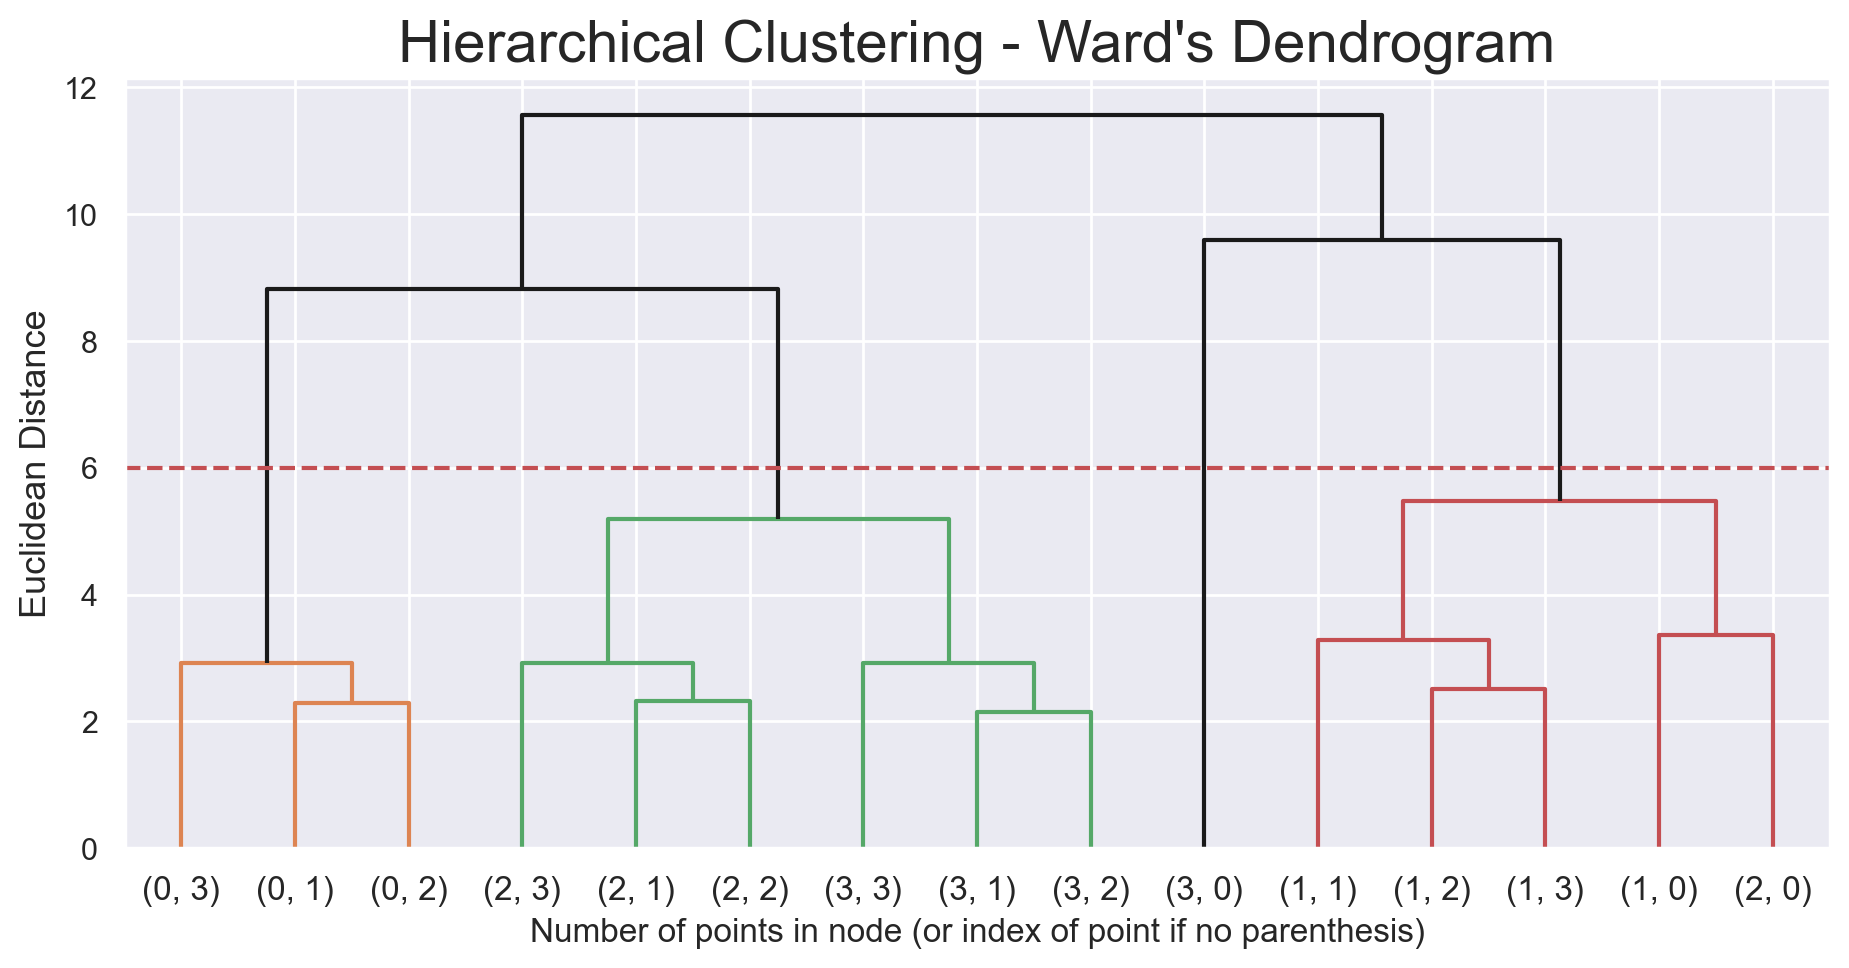

In [159]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 6
dendrogram(linkage_matrix,
           truncate_mode='level',
           labels=df_centroids.index, p=5,
           color_threshold=y_threshold,
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [160]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward',
    metric='euclidean',
    n_clusters= 4
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

Week_days_mean  Weekend_days_mean  \
behavior_labels demographic_labels                                      
0               1                        -0.751991          -0.231065   
                2                        -0.244243          -0.665043   
                3                        -0.415006          -0.509156   
1               0                         2.643668           2.397692   
                1                         0.217447           1.431748   
                2                         1.161711           0.191070   
                3                         0.993948           0.611116   
2               0                         1.362295           1.476830   
                1                        -0.448055           0.466399   
                2                         0.100996          -0.376338   
                3                        -0.045487          -0.147507   
3               0                         3.003722           2.492468   
                1                        -0.785647          -0.381670   
                2                        -0.371462          -0.793877   
                3                        -0.532486          -0.626703   

                                     HR_peak  DOW_Peak  customer_age  \
behavior_labels demographic_labels                                     
0               1                  -0.119686  1.095636     -0.308518   
                2                  -0.445215 -0.694836     -0.409752   
                3                  -0.239502 -0.058246      1.652014   
1               0                   0.259150  0.026286     -0.032108   
                1                  -0.113236  1.128275     -0.298159   
                2                  -0.515128 -0.754578     -0.399978   
                3                  -0.251336 -0.240753      1.766540   
2               0                   0.581858  0.074127     -0.113998   
                1                   0.145211  1.015737     -0.298449   
                2                  -0.152381 -0.773894     -0.405420   
                3                  -0.001406 -0.261713      1.637067   
3               0                   0.555334 -0.331684      0.615863   
                1                   0.333608  1.114218     -0.309236   
                2                   0.040983 -0.654034     -0.434995   
                3                   0.218165  0.069088      1.658997   

                                    CUI_American  CUI_Italian  CUI_Asian  \
behavior_labels demographic_labels                                         
0               1                      -0.207039    -0.126111   0.119675   
                2                      -0.162852    -0.228764   0.303792   
                3                      -0.183220    -0.195074   0.201457   
1               0                       0.940416     0.850768   1.451959   
                1                       1.233716     0.628042   1.027043   
                2                       1.036805     0.178602   1.316880   
                3                       1.198225     0.204714   1.302538   
2               0                      -0.159116    -0.077167   0.045127   
                1                      -0.058183     0.076537  -0.155610   
                2                      -0.092625    -0.093823  -0.153940   
                3                      -0.071640    -0.020832  -0.162515   
3               0                      -0.456579    -0.311530   1.031893   
                1                      -0.285701    -0.178818  -0.460219   
                2                      -0.286718    -0.216937  -0.416994   
                3                      -0.293314    -0.198544  -0.440124   

                                    CUI_OTHER  Chain_Preference  \
behavior_labels demographic_labels                                
0               1                    0.297981         -0.489157   
                2                    0.626623         -0.466330   
        

In [161]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_hie = final_df_ohc.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_hie['merged_labels'] = df_hie.apply(
    lambda row: cluster_mapper[
        (row['behavior_labels'], row['demographic_labels'])
    ], axis=1
)

# Merged cluster centroids
df_hie.groupby('merged_labels').mean()[metric_features]

Week_days_mean  Weekend_days_mean   HR_peak  DOW_Peak  \
merged_labels                                                          
0                    1.779669           1.620577  0.023438  0.021008   
1                   -0.227759          -0.202342  0.030730 -0.016709   
2                    3.003722           2.492468  0.555334 -0.331684   
3                   -0.470603          -0.469791 -0.282850  0.109544   

               customer_age  CUI_American  CUI_Italian  CUI_Asian  CUI_OTHER  \
merged_labels                                                                  
0                  0.009382      0.972005     0.584057   1.278688   1.133295   
1                 -0.001389     -0.133193    -0.071134  -0.231008  -0.240493   
2                  0.615863     -0.456579    -0.311530   1.031893   1.574890   
3                 -0.001344     -0.183538    -0.183149   0.214470   0.482506   

               Chain_Preference  Order_Frequency  Avg_Spend_per_Order  \
merged_labels                                                           
0                     -0.050999        -0.421759            -0.042748   
1                      0.066791        -0.019261            -0.256917   
2                      0.556403         5.351704            -0.717208   
3                     -0.480622         0.707333             2.161161   

               Product_per_Order  Total_Orders  Customer_Duration  \
merged_labels                                                       
0                       0.177355      1.970769           1.261336   
1                      -0.287046     -0.249610          -0.109757   
2                       0.161345      3.201209          -0.998986   
3                       2.118672     -0.542390          -0.754646   

               behavior_labels  demographic_labels  
merged_labels                                       
0                     1.049338            0.802908  
1                     2.264438            1.831816  
2                     3.000000            0.000000  
3                     0.000000            1.793597

In [162]:
# Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_hie.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['behavior_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['demographic_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])

# Create pivot table and replace NaN with 0
df_counts_pivot = df_counts.pivot(values=0, index='behavior_labels', columns='demographic_labels')\
    .fillna(0)
df_counts_pivot

demographic_labels       0        3
behavior_labels                    
0                      0.0   2936.0
2                   3851.0      0.0
3                      2.0  24051.0

We opted to select manual clustering for our merging approach, since it offers more control over the process of forming clustering. Contrarily to hierarchical clustering, that uses distance-based algorithms, by merging manually the cluster we can better control the formation of imbalanced clusters. This approach ensures that the final groupings better align with real-world needs.

### Updating cluster labels on manual merge

In [175]:
df_manual["behavior_labels"].replace({2:0, 3:1}, inplace=True)
df_manual["demographic_labels"].replace({1:0, 2:1, 3: 2}, inplace=True)

# Define the replacement dictionary
replacement_dict = {(2, 2): 0, (3, 2): 1, (2, 3): 2, (2, 1): 3}

# Replace tuples using apply
df_manual["merged_labels"] = df_manual["merged_labels"].apply(lambda x: replacement_dict.get(x, x))

array([0, 1, 2, 3], dtype=int64)

#### Cluster Analysis

* Profiling with the manual merge:

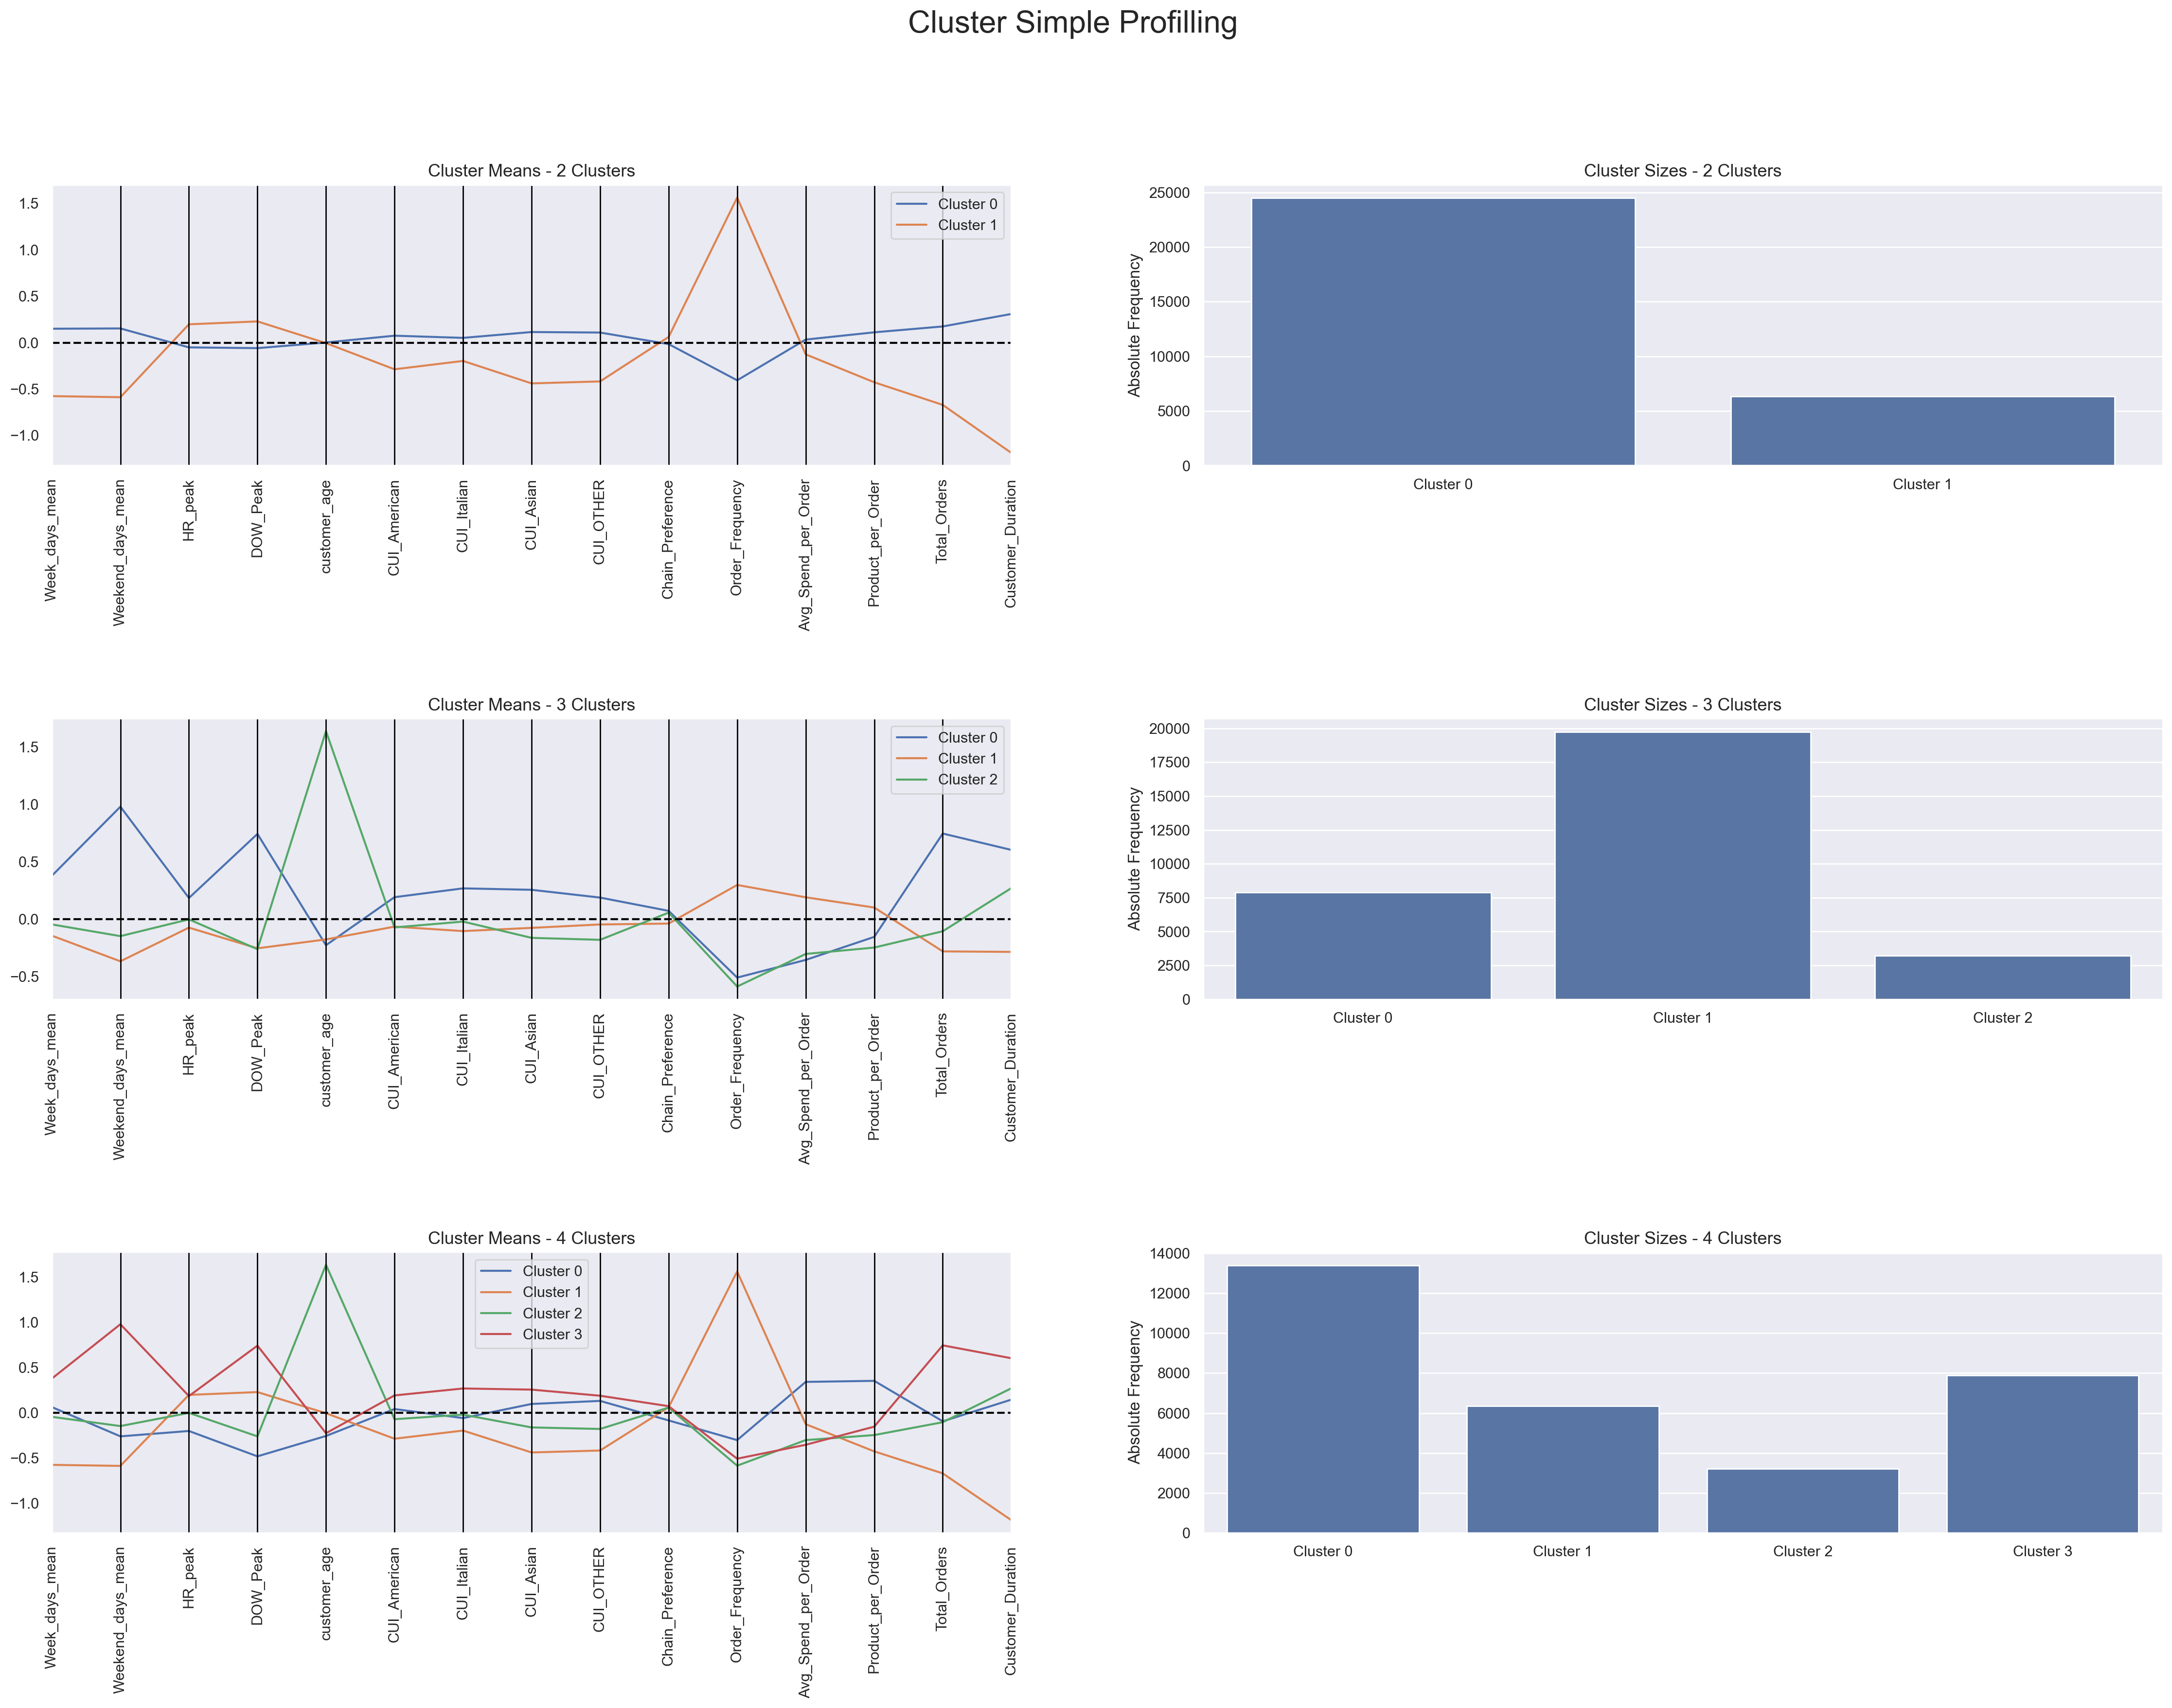

In [179]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(28, 18), squeeze=False)

for ax, label in zip(axes, ['behavior_labels', 'demographic_labels', 'merged_labels']):
    # Filtering df
    drop_cols = [i for i in ['behavior_labels', 'demographic_labels', 'merged_labels'] if i!=label]
    dfax = df_manual.drop(drop_cols, axis=1)

    # Getting the cluster centroids and counts
    centroids = dfax.groupby(by=label, as_index=False).mean()
    counts = dfax.groupby(by=label, as_index=False).count().iloc[:, [0, 1]]
    counts.columns = [label, "counts"]

    # Setting Data
    pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
    sns.barplot(x=counts[label].unique().tolist(), y="counts", data=counts, ax=ax[1])


    #Setting Layout
    handles, _ = ax[0].get_legend_handles_labels()
    cluster_labels = ["Cluster {}".format(i) for i in counts[label].unique().tolist()]
    ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters

    ax[0].axhline(color="black", linestyle="--")
    ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
    ax[1].set_xticklabels(cluster_labels)
    ax[1].set_xlabel("")
    ax[1].set_ylabel("Absolute Frequency")
    ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)


plt.subplots_adjust(hspace=0.90, top=0.88)
plt.suptitle("Cluster Simple Profilling", fontsize=23)
plt.show()

#### Updating the final dataset

In [180]:
# Setting df to have the final product, behavior and merged clusters of manual clustering
final_df_ohc = df_manual.copy()

# 5. Profiling with RFM

In [234]:
final_df_ohc = pd.concat([final_df_ohc, df_RFM.drop(columns=["R", "F", "M"])], axis=1)

final_df_ohc.head()

Week_days_mean  Weekend_days_mean   HR_peak  DOW_Peak  \
customer_id                                                          
1b8f824d5e        -0.445376          -0.431336  1.208591 -1.320198   
5d272b9dcb        -0.445376          -0.431336 -0.284567 -1.320198   
f6d1b2ba63        -0.445376          -0.431336 -0.471211 -1.320198   
180c632ed8        -0.445376          -0.431336 -0.097922 -0.825941   
4eb37a6705        -0.445376          -0.431336 -0.657856 -0.825941   

             customer_age  CUI_American  CUI_Italian  CUI_Asian  CUI_OTHER  \
customer_id                                                                  
1b8f824d5e      -1.446788     -0.456579     -0.31153   0.453449  -0.594483   
5d272b9dcb      -1.605453      0.813936     -0.31153  -0.397661  -0.594483   
f6d1b2ba63       1.726520      0.455179     -0.31153  -0.639483  -0.594483   
180c632ed8      -0.177464     -0.456579     -0.31153   0.554871  -0.594483   
4eb37a6705      -1.129457      0.987368     -0.31153   0.907197  -0.594483   

             Chain_Preference  ...  behavior_labels  demographic_labels  \
customer_id                    ...                                        
1b8f824d5e          -0.331571  ...                0                   1   
5d272b9dcb           0.960027  ...                1                   1   
f6d1b2ba63           0.960027  ...                1                   1   
180c632ed8          -0.331571  ...                1                   1   
4eb37a6705          -1.623169  ...                0                   1   

             merged_labels  Recency  Frequency  Monetary  RFM_Group  \
customer_id                                                           
1b8f824d5e               0        1          2     28.88      1-1-3   
5d272b9dcb               1        1          2     19.21      1-1-2   
f6d1b2ba63               1        1          2      9.20      1-1-1   
180c632ed8               1        2          2     31.56      1-1-3   
4eb37a6705               0        2          2     55.44      1-1-4   

             RFM_Score  RFM_Segment   RFM_Vgroup  
customer_id                                       
1b8f824d5e           5    Mid-Value      At Risk  
5d272b9dcb           4    Low-Value  Almost Lost  
f6d1b2ba63           3    Low-Value         Lost  
180c632ed8           5    Mid-Value      At Risk  
4eb37a6705           6    Mid-Value      At Risk  

[5 rows x 25 columns]

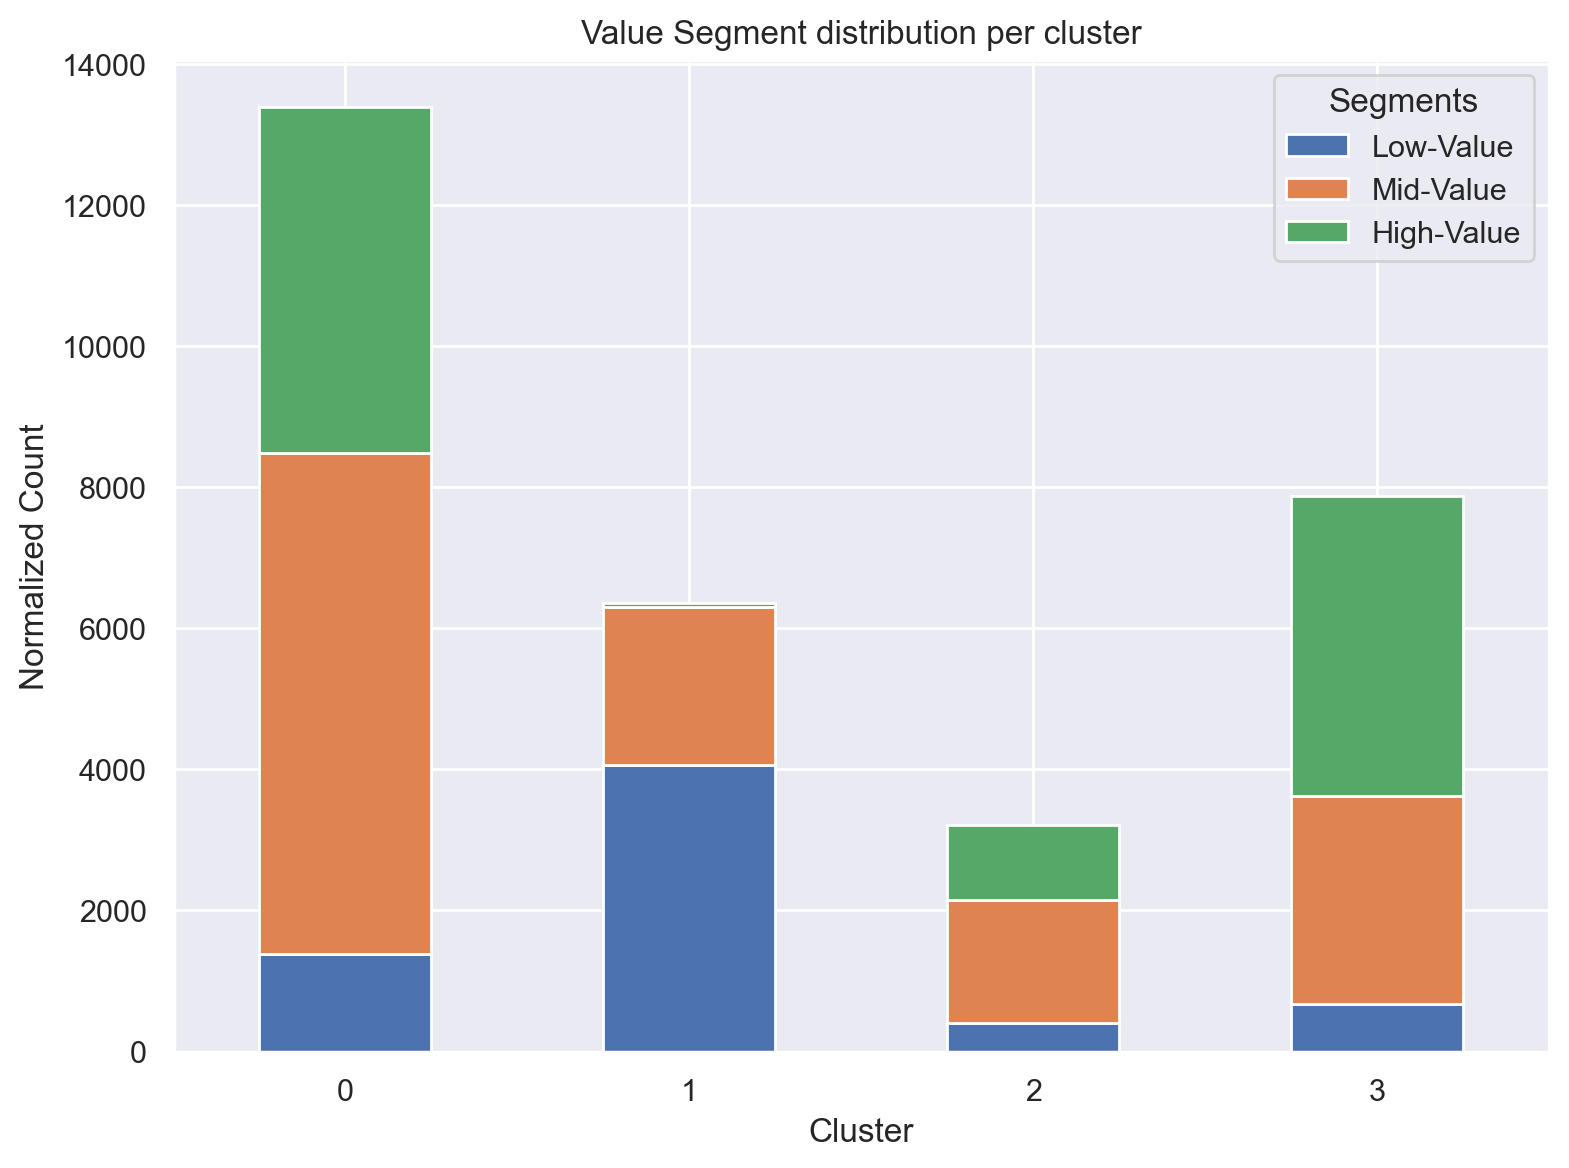

In [235]:
# Group by 'merged_labels' and 'RFM_Segment', calculate normalized counts
segment_distribution = final_df_ohc.groupby(['merged_labels'])["RFM_Segment"].value_counts().reset_index(name="count")

# Create a dictionary to map RFM_Segment values to their order
segment_order = {'Low-Value': 0, 'Mid-Value': 1, 'High-Value': 2}  # Adjust if order is different

# Pivot table with fill value and custom column order
segment_distribution = segment_distribution.pivot_table(
    index='merged_labels', columns='RFM_Segment', values='count', fill_value=0
)

segment_distribution = segment_distribution[["Low-Value", "Mid-Value", "High-Value"]]

# Plotting
segment_distribution.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title('Value Segment distribution per cluster')
plt.xlabel('Cluster')
plt.ylabel('Normalized Count')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(title='Segments')
plt.tight_layout()

plt.show()

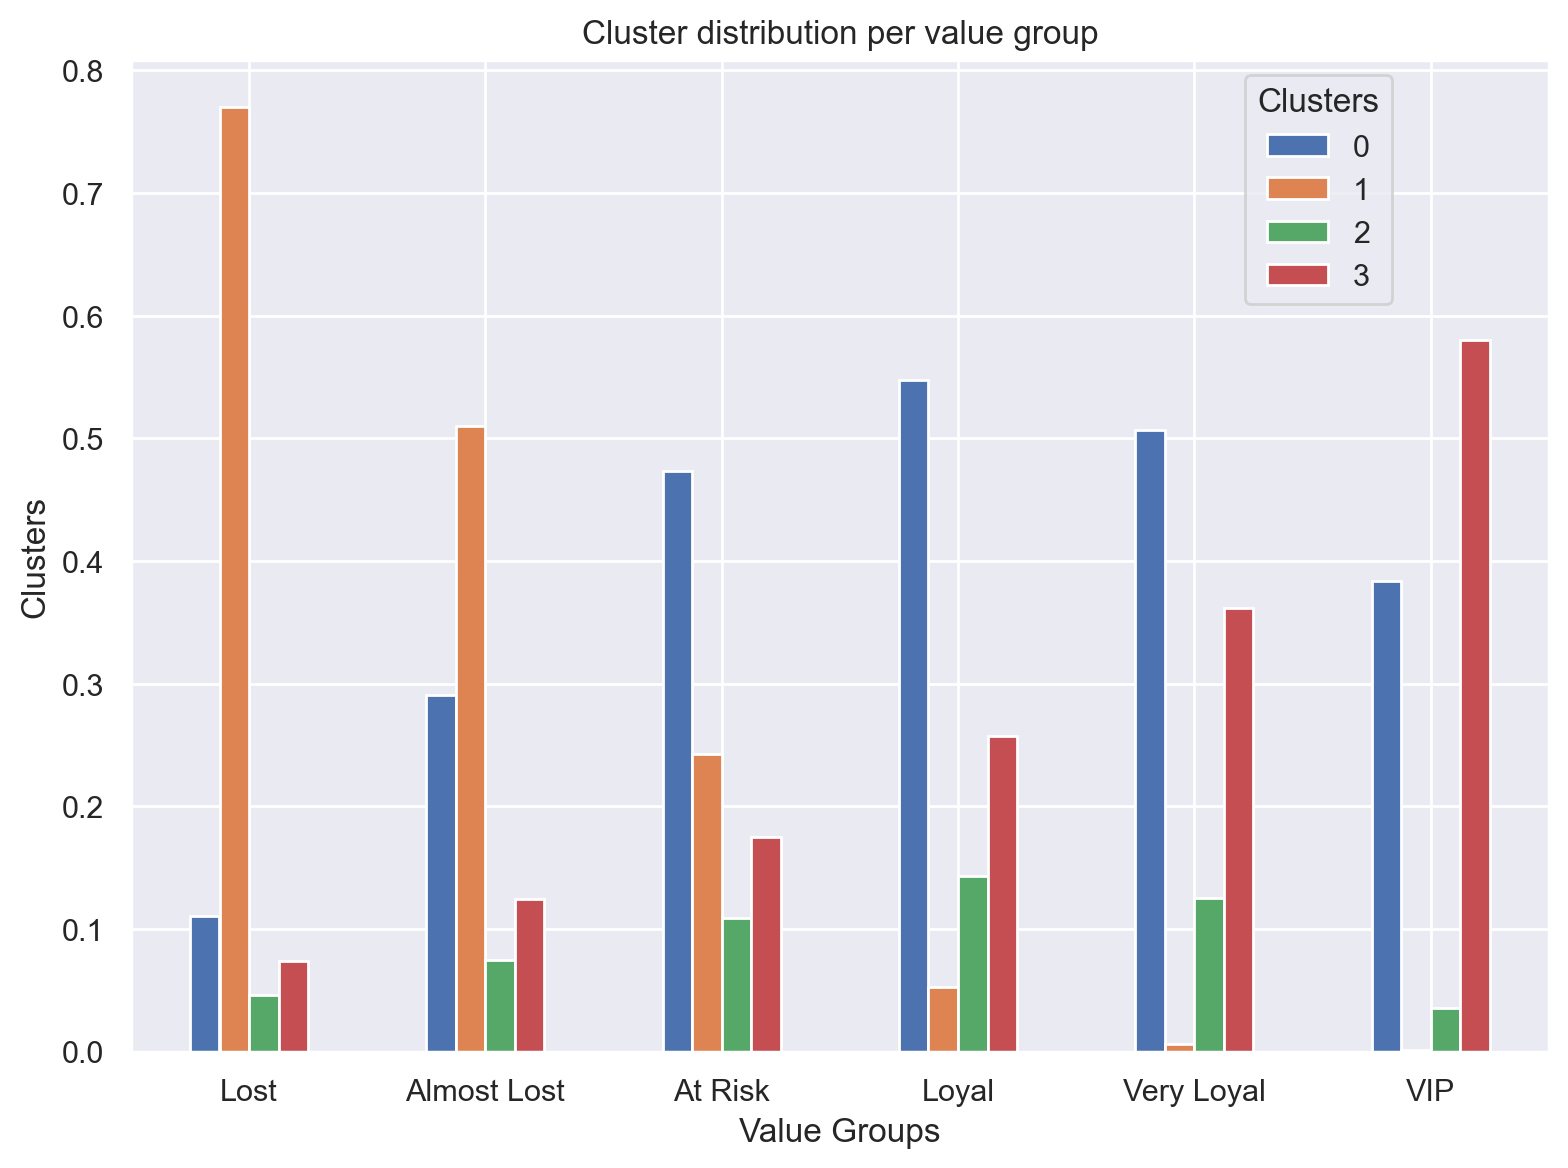

In [237]:
vgroup_order = {"Lost":0, "Almost Lost":1, "At Risk":2, "Loyal":4, "Very Loyal":5, "VIP":6}

# Group by 'merged_labels' and 'RFM_Segment' and calculate the normalized counts
cluster_distribution_pvg = final_df_ohc.groupby(['RFM_Vgroup'])["merged_labels"].value_counts(normalize=True).reset_index(name="freq")

cluster_distribution_pvg = cluster_distribution_pvg.pivot_table(index='RFM_Vgroup', columns='merged_labels', values='freq', fill_value=0)

cluster_distribution_pvg = cluster_distribution_pvg.reindex(vgroup_order)

# Plotting
cluster_distribution_pvg.plot(kind='bar', figsize=(8, 6))  # figsize for better visualization

plt.title('Cluster distribution per value group')
plt.xlabel('Value Groups')
plt.ylabel('Clusters')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(title='Clusters', loc='upper right', bbox_to_anchor=(0.9, 1))  # Adjust x-offset for better positioning
plt.tight_layout() # Adjusts layout to prevent labels from overlapping
plt.show()